In [1]:
from torch.quasirandom import SobolEngine
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import botorch
import wandb
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model
from mgp_models.utils import *
from mgp_models.acquisition import *
from mgp_models.test_functions import *
import time
import scipy
from torchrl.modules import TruncatedNormal
import warnings
warnings.filterwarnings('ignore')


c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [2]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
import torch

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from botorch.posteriors.fully_bayesian import GaussianMixturePosterior, MCMC_DIM


In [3]:
torch.max(torch.tensor([1]),0)[0]

tensor(1)

In [4]:
tkwargs = {
"device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
"dtype": torch.double,
}

In [5]:
# class SALHellingerMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         up = 2*torch.sqrt(sigma_1)*torch.sqrt(sigma_2)
#         down = sigma_1+sigma_2
#         to_sqrt = up.div(down)
#         sqrted = torch.sqrt(to_sqrt)
#         mean_up = mu_1 - mu_2
#         mean_up = mean_up.pow(2)
#         exped = torch.exp(-0.25*mean_up.div(down))
#         right = sqrted* exped
#         hellinger = 1 - right
#         return hellinger.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        



In [6]:
# class SALWassersteinMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         diff_means = mu_1-mu_2
#         diff_stds = torch.sqrt(sigma_2) - torch.sqrt(sigma_1)
#         wasserstein = torch.sqrt(diff_means.pow(2)+diff_stds.pow(2))
#         return wasserstein.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        

In [7]:
# class BALDKLMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.selected_mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
#         dif_means = mu_1-mu_2
#         up = sigma_1 + dif_means.pow(2)
#         KL = left + up.div(2*sigma_2) - 0.5
#         return KL.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)

In [5]:
from gpytorch.models import ExactGP
class NewExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, dim, tkwargs):
        super(NewExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean().to(**tkwargs)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=dim)
        ).to(**tkwargs)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def eval_new_mll(test_X, test_Y, train_X, train_Y, tkwargs, learning_steps=300, lr=0.1, patience=15):


    train_x, train_y = None, None # Your training data
    new_likelihood = gpytorch.likelihoods.GaussianLikelihood().to(**tkwargs)
    dim = test_X.size()[1]
# Given parameters
    new_model = NewExactGPModel(train_X, train_Y.squeeze(), new_likelihood,dim, tkwargs)
    new_model.train()
    new_likelihood.train()
    #new_model.set_train_data(train_X, train_Y.squeeze(), strict=False)
    optimizer = torch.optim.Adam(new_model.parameters(), lr=lr, foreach=False )  # Includes GaussianLikelihood parameters
    #mll = get_mll_best_model(gp, best_gp_index, train_X, train_Y, test_X, test_Y)
    best_loss = float('inf')
    patience = 15  # Adjust this value based on your preference
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(new_likelihood, new_model)
    for i in range(learning_steps):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        output = new_model(train_X)
        loss = -mll(output, train_Y.squeeze())
        loss.backward()
        #if print_iter:
        if i == 0 or loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                #if print_iter:
                #print(f'Early stopping at iteration {i + 1} with best loss: {best_loss}')
                break
        optimizer.step()
        #maybe add likelihoods to the model parameters
    #ll = mll(output, train_Y.squeeze())
    new_model.eval()
    new_likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = new_model(test_X)
        mll = ExactMarginalLogLikelihood(new_likelihood, new_model)
        test_mll = mll(predictions, test_Y.squeeze())
        rmse = gpytorch.metrics.mean_squared_error(predictions, test_Y, squared=True)
        predictions.mean
    return -test_mll, rmse, predictions.mean
#---------------------------------------CHECK IF BEING UPDATED



In [9]:
import matplotlib.pyplot as plt
import numpy as np
def plot_truncs(test_X, trunc_means, trunc_vars, mask):
    plt.figure(figsize=(10, 6))
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    y = synthetic_function.evaluate_true(test_X)
    if NEGATE:
        y=-y
    x = test_X.detach().squeeze().numpy()
    y = y.detach().squeeze().numpy()
    gps_y = trunc_means.detach().numpy()
    gps_var = trunc_vars.detach().numpy()
    print(gps_y.shape)
    df = pd.DataFrame({'x': x, 'y':y})

    gp_cols = ['gp_' + str(i) for i in range(gps_y.shape[0])]
    for i, gp_col in enumerate(gp_cols):
        if mask[i]:
            for j in range(gps_y.shape[2]):
                df[gp_col+'_'+str(j)] = gps_y[i,:,j]
                df[gp_col+'_'+str(j)+'upper'] =df[gp_col+'_'+str(j)] + 1.96 * np.sqrt(gps_var[i,:,j])
                df[gp_col+'_'+str(j)+'lower'] =df[gp_col+'_'+str(j)] - 1.96 * np.sqrt(gps_var[i,:,j])
    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)
    for i in range(2, len(df.columns), 3):
        plt.plot(df.x, df[df.columns[i]], color='blue', alpha=0.4)
        plt.fill_between(df.x, df[df.columns[i]+'lower'], df[df.columns[i]+'upper'], color='orange', alpha=0.1)
    plt.plot(df.x, df.y, color='red', alpha=1)
    plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_yhat(gp, test_X, tkwargs, ll=None, batch_size = 100):

    total_batches = test_X.size(0) // batch_size
    Y_full = torch.Tensor().to(**tkwargs)
    Y_mms =  torch.Tensor().to(**tkwargs)
    var_mms = torch.Tensor().to(**tkwargs)
    Y_selecteds = torch.Tensor().to(**tkwargs)
    if total_batches==0:
        posterior = gp.posterior(test_X, ll=ll)
        Y_full = posterior.mean
        Y_mms = posterior.weighted_mixture_mean
        var_mm = posterior.QBMGP
        Y_selecteds  = posterior.selected_mixture_mean
    else:
        for i in range(total_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            batch_X = test_X[start_idx:end_idx]
            posterior = gp.posterior(batch_X, ll=ll)
            Y_hat = posterior.mean
            Y_mm = posterior.weighted_mixture_mean
            var_mm = posterior.QBMGP
            Y_selected  = posterior.selected_mixture_mean
            Y_mms = torch.cat((Y_mms, Y_mm),0)
            var_mms = torch.cat((var_mms, var_mm),0)
            Y_selecteds = torch.cat((Y_selecteds, Y_selected),0)
            Y_full = torch.cat((Y_full, Y_hat),1)
    return Y_full, Y_mms, var_mms, Y_selecteds
import seaborn as sns  # Import seaborn for KDE plot


def plot_gps(test_X, std, synthetic_function, Y_hat, X_train, Y_train,acq_values=None, Y_mms=None, var_mms=None,Y_selecteds =None, weights=None, mgp=False, negate=False):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    if negate:
        y=-y
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()
    if acq_values is not None:
        acq_values = acq_values.detach().squeeze().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    if acq_values is not None:
        df['acq_values'] = acq_values

    gp_cols = ['gp_' + str(i) for i in range(len(gps_y))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = gps_y[i]
    if mgp:
        df['mean_mgp'] = Y_mms.detach().numpy()
        df['mean_mgp_selected'] = Y_selecteds.detach().numpy()
        df['var_mgp'] = var_mms.detach().numpy()
        df['mgp_ci_upper'] =df['mean_mgp'] + 1.96 * np.sqrt(df['var_mgp'])
        df['mgp_ci_lower'] =df['mean_mgp'] - 1.96 * np.sqrt(df['var_mgp'])
    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)
    if weights is not None:
        norm = plt.Normalize(min(weights), max(weights))
        cmap = plt.cm.viridis

    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI function')
    for i, gp_col in enumerate(gp_cols):
        if weights is None or weights[i] > 0:
            color = cmap(norm(weights[i])) if weights is not None else 'cornflowerblue'
            ax1.plot(df.x, df[gp_col], color=color, alpha=0.7)
    ax1.scatter(x_points, y_points, color='black', s=80, marker='x', label='Queried points', zorder=5)
    ax1.legend()
    ax1.set_ylabel('Y')
    if mgp:
        ax1.plot(df.x, df['mean_mgp'], color='blue', label='MGP mean')
        ax1.fill_between(df.x, df.mgp_ci_lower, df.mgp_ci_upper, color='orange', alpha=0.3, label='95% CI MGP')
    # Determine the limits for the x-axis based on the upper plot
    x_min, x_max = ax1.get_xlim()

    # Plotting the KDE for acq_values on the second subplot (ax2) with x-axis limits
    if acq_values is not None:
    #     sns.kdeplot(x=df.x, weights=df.acq_values, ax=ax2, fill=True, color='green', clip=(x_min, x_max), bw_adjust=0.5)
    # else:
        sns.lineplot(x=df.x, y=df.acq_values, ax=ax2, color='green' )
        plt.fill_between(x=df.x, y1=df.acq_values, y2= df.acq_values.min(), color='green', alpha=.5)
        ax2.set_xlim(x_min, x_max)  # Apply the same x-axis limits as the upper plot
        ax2.set_ylabel('Acquisition Value Density')
        ax2.set_xlabel('X')

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_samples_gp(test_X, std, synthetic_function,Y_hat, samples, index, X_train, Y_train, variance=None, last=False):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()
    if last:
         x_last = x_points[-1]
         y_last = y_points[-1]
    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})

    samples_selected = samples[:,index,:].detach().numpy()
    df['gp_mean'] = gps_y[index,:]

    if variance is not None:
        gps_y_var = variance.detach().squeeze().numpy()
        df['gp_var'] = gps_y_var[index,:]
        df['gp_ci_upper'] =df['gp_mean'] + 1.282 * np.sqrt(df['gp_var'])
        df['gp_ci_lower'] =df['gp_mean'] - 1.282 * np.sqrt(df['gp_var'])
    gp_cols = ['gp_' + str(i) for i in range(len(samples_selected))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = samples_selected[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)


    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    if variance is not None:
         ax1.fill_between(df.x, df.gp_ci_lower, df.gp_ci_upper, color='orange', alpha=0.3, label='80% CI gp')
    for i, gp_col in enumerate(gp_cols):
            color = 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='black', s=80, marker='x', label='Queried points', zorder=5)
    if last:
         ax1.scatter(x_last, y_last, color='gold', s=300, marker='*', label="fantasized optimum", zorder=6)
    ax1.legend()
    ax1.plot(df.x, df.gp_mean, color='darkorange')
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [12]:
class BatchGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, dimensions,  batch_size, likelihood):
        #likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([batch_size]))
        super(BatchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([batch_size]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=dimensions, 
                                       batch_shape=torch.Size([batch_size])),
            batch_shape=torch.Size([batch_size])
        )
    
    def forward(self, x):
        # x is expected to be of shape [batch size, number of data points, features]
        # Ensure that the kernel can handle multidimensional input properly
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def load_params(self, param_dict):
        # self.covar_module.base_kernel.lengthscale = param_dict['lengthscale']
        # self.covar_module.outputscale = param_dict['outputscale']
        # self.mean_module.constant = param_dict['mean']
        # self.likelihood.noise_covar.noise = param_dict['noise']
        
        new_state_dict = {}
        new_state_dict['likelihood.noise_covar.raw_noise'] = param_dict['noise']
        new_state_dict['mean_module.raw_constant'] = param_dict['mean']
        new_state_dict['covar_module.raw_outputscale'] = param_dict['outputscale']
        new_state_dict['covar_module.base_kernel.raw_lengthscale'] = param_dict['lengthscale']
        self.load_state_dict(new_state_dict)

    def condition_on_data(self, X, y):
        self.set_train_data(inputs=X, targets=y, strict=False)
        
    def load_params_new(self, param_dict):
        self.covar_module.base_kernel.lengthscale = param_dict['lengthscale']
        self.covar_module.outputscale = param_dict['outputscale']
        self.mean_module.constant = param_dict['mean']
        self.likelihood.noise_covar.noise = param_dict['noise']


In [13]:
from botorch.utils.transforms import unnormalize
from typing import Any, Generator, Iterable, List, Optional, Tuple, TYPE_CHECKING
from botorch.sampling.pathwise.paths import SamplePath
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths
import torch
from torch import Tensor
from torch.quasirandom import SobolEngine
from botorch.models.model import Model

def optimize_posterior_samples(
    paths: SamplePath,
    bounds: Tensor,
    candidates: Optional[Tensor] = None,
    raw_samples: Optional[int] = 1024,
    num_restarts: int = 20,
    maximize: bool = True,
    **kwargs: Any,
) -> Tuple[Tensor, Tensor]:
    r"""Cheaply maximizes posterior samples by random querying followed by vanilla
    gradient descent on the best num_restarts points.

    Args:
        paths: Random Fourier Feature-based sample paths from the GP
        bounds: The bounds on the search space.
        candidates: A priori good candidates (typically previous design points)
            which acts as extra initial guesses for the optimization routine.
        raw_samples: The number of samples with which to query the samples initially.
        num_restarts: The number of points selected for gradient-based optimization.
        maximize: Boolean indicating whether to maimize or minimize

    Returns:
        A two-element tuple containing:
            - X_opt: A `num_optima x [batch_size] x d`-dim tensor of optimal inputs x*.
            - f_opt: A `num_optima x [batch_size] x 1`-dim tensor of optimal outputs f*.
    """
    if maximize:

        def path_func(x):
            return paths(x)

    else:

        def path_func(x):
            return -paths(x)

    candidate_set = unnormalize(
        SobolEngine(dimension=bounds.shape[1], scramble=True).draw(raw_samples), bounds
    )

    # queries all samples on all candidates - output shape
    # raw_samples * num_optima * num_models
    candidate_queries = path_func(candidate_set)
    argtop_k = torch.topk(candidate_queries, num_restarts, dim=-1).indices
    X_top_k = candidate_set[argtop_k, :]

    # to avoid circular import, the import occurs here
    from botorch.generation.gen import gen_candidates_torch

    X_top_k, f_top_k = gen_candidates_torch(
        X_top_k, path_func, lower_bounds=bounds[0], upper_bounds=bounds[1], **kwargs
    )
    f_opt, arg_opt = f_top_k.max(dim=-1, keepdim=True)

    # For each sample (and possibly for every model in the batch of models), this
    # retrieves the argmax. We flatten, pick out the indices and then reshape to
    # the original batch shapes (so instead of pickig out the argmax of a
    # (3, 7, num_restarts, D)) along the num_restarts dim, we pick it out of a
    # (21  , num_restarts, D)
    final_shape = candidate_queries.shape[:-1]
    X_opt = X_top_k.reshape(final_shape.numel(), num_restarts, -1)[
        torch.arange(final_shape.numel()), arg_opt.flatten()
    ].reshape(*final_shape, -1)
    if not maximize:
        f_opt = -f_opt
    return X_opt, f_opt


In [14]:

def normal_to_truncnorm(all_means, all_vars, all_maxs):
    #https://en.wikipedia.org/wiki/Truncated_normal_distribution
    Norm = torch.distributions.normal.Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
    betas = all_maxs
    betas = all_maxs - all_means
    betas = betas/torch.sqrt(all_vars)
    pdf_betas=Norm.log_prob(betas).exp()
    cdf_betas = Norm.cdf(betas)
    tnorm_mean = all_means -torch.sqrt(all_vars)*pdf_betas.div(cdf_betas)
    right = pdf_betas.div(cdf_betas)
    right = right.pow(2)
    left = betas*pdf_betas.div(cdf_betas) 
    tnorm_var = 1-left-right
    tnorm_var = all_vars*tnorm_var
    return tnorm_mean, tnorm_var

def get_truncated_moments(gp, X_to_condition_complete,Y_to_condition_complete, X, Y, X_test, num_optima=3):
    # path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([num_optima]))
    # samples =path(grid)
    n_models = X_to_condition_complete.size()[1]
    X_test_size = X_test.size()[0]
    model_dim = X.size()[1]
    # max_obj = samples.max(dim=2)
    # maximun_index = max_obj[1]
    # maximuns = max_obj[0]
    # X_to_condition_complete = grid[maximun_index]
    list_means, list_variances = [], []
    for index in range(num_optima):
        X_to_condition= X_to_condition_complete[index, :,:].unsqueeze(1)
        Y_to_condition = Y_to_condition_complete[index]
        X_with_new_max = torch.cat([X.repeat(n_models,1,1), X_to_condition], dim=1)
        Y_with_new_max = torch.cat([Y.repeat(n_models,1,1).squeeze(), Y_to_condition], dim=1)
        Y_with_new_max, _ = gp.outcome_transform(Y_with_new_max, None)
        batch_gp = BatchGPModel(None,
                None,
                dimensions=model_dim,
                batch_size=n_models, 
                likelihood = gp.likelihood)
        #batch_gp.load_params(gp.get_param_dict())
        batch_gp.condition_on_data(X_with_new_max, Y_with_new_max)
        batch_gp.load_params_new(gp.get_param_dict())
        batch_gp.eval()
        batch_gp.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = batch_gp.likelihood(batch_gp(X_test))
            means, vars = gp.outcome_transform.untransform(predictions.mean,predictions.variance)
                        
            list_means.append(means.unsqueeze(-1))
            list_variances.append(vars.unsqueeze(-1))
            #list_means.append(predictions.mean.unsqueeze(-1))
            #list_variances.append(predictions.variance.unsqueeze(-1))
    print('train_outputs')
    print(batch_gp.train_targets)
    print('X')
    print(Y)
    all_means = torch.cat(list_means, -1).swapaxes(-1,1)
    all_vars = torch.cat(list_variances, -1).swapaxes(-1,1)
    all_maxs = Y_to_condition_complete.repeat(1,1,X_test_size).detach().swapaxes(0,1)
    tnorm_mean, tnorm_var = normal_to_truncnorm(all_means, all_vars, all_maxs)
    print('all_means')
    print(all_means)
    print('all_maxs')
    print(all_maxs)
    return tnorm_mean.swapaxes(-1,-2), tnorm_var.swapaxes(-1,-2)

In [15]:

def get_optimal_samples(
    model: Model,
    bounds: Tensor,
    num_optima: int,
    raw_samples: int = 1024,
    num_restarts: int = 20,
    maximize: bool = True,
) -> Tuple[Tensor, Tensor]:
    """Draws sample paths from the posterior and maximizes the samples using GD.

    Args:
        model (Model): The model from which samples are drawn.
        bounds: (Tensor): Bounds of the search space. If the model inputs are
            normalized, the bounds should be normalized as well.
        num_optima (int): The number of paths to be drawn and optimized.
        raw_samples (int, optional): The number of candidates randomly sample.
            Defaults to 1024.
        num_restarts (int, optional): The number of candidates to do gradient-based
            optimization on. Defaults to 20.
        maximize: Whether to maximize or minimize the samples.
    Returns:
        Tuple[Tensor, Tensor]: The optimal input locations and corresponding
        outputs, x* and f*.

    """
    paths = draw_matheron_paths(model, sample_shape=torch.Size([num_optima]))
    optimal_inputs, optimal_outputs = optimize_posterior_samples(
        paths,
        bounds=bounds,
        raw_samples=raw_samples,
        num_restarts=num_restarts,
        maximize=maximize,
    )
    return optimal_inputs, optimal_outputs

class ScoreBOHellinger(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:
        num_optima = 8
        model_dim = self.model.train_inputs[0].size()[1]
        bounds = torch.tensor([[0],[1]]).repeat(1,model_dim)
        opt_inputs, opt_outputs = get_optimal_samples(model=self.model,bounds=bounds, num_optima=num_optima)
        posterior = self.model.posterior(X, ll= self.ll)
        n_models = posterior._mean.shape[MCMC_DIM]
        print('original Y')
        print(self.model.original_targets)
        tnorm_mean, tnorm_var = get_truncated_moments(gp=self.model,
                                                        X_to_condition_complete=opt_inputs,
                                                        Y_to_condition_complete=opt_outputs,
                                                        X=self.model.train_inputs[0],
                                                        Y=self.model.original_targets,
                                                        X_test=X,
                                                        num_optima=num_optima)
        print(tnorm_mean.size)
        plot_truncs(X,tnorm_mean,tnorm_var, posterior.mask)
        mean_minus_mgpmean = posterior._mean.repeat(1,1,num_optima) - posterior.selected_mixture_mean.unsqueeze(0).repeat(n_models,1,num_optima)
        BQBC = mean_minus_mgpmean.pow(2).mul(posterior.shaped_weights.repeat(1,1,num_optima)).sum(dim=MCMC_DIM)#.div(posterior.n_active_models)
        var = posterior.weighted_variance.repeat(1,num_optima)
        mixture_variance = BQBC + var
        sigma_1 = mixture_variance.repeat(n_models,1,1)
        mu_1 = posterior.weighted_mixture_mean.repeat(n_models,1,num_optima)
        sigma_2 = tnorm_var
        mu_2 = tnorm_mean
        up = 2*torch.sqrt(sigma_1)*torch.sqrt(sigma_2)
        down = sigma_1+sigma_2
        to_sqrt = up.div(down)
        sqrted = torch.sqrt(to_sqrt)
        mean_up = mu_1 - mu_2
        mean_up = mean_up.pow(2)
        exped = torch.exp(-0.25*mean_up.div(down))
        right = sqrted* exped
        hellinger = 1 - right
        return hellinger.mul(posterior.shaped_mask.repeat(1,1,num_optima)).sum(dim=MCMC_DIM).sum(dim=-1)

In [8]:
DIM = 1
BOUNDS =  [[-32.768, 32.768]]
#BOUNDS = [[0, 20]]
type = 'part_bayesian'
NEGATE=True

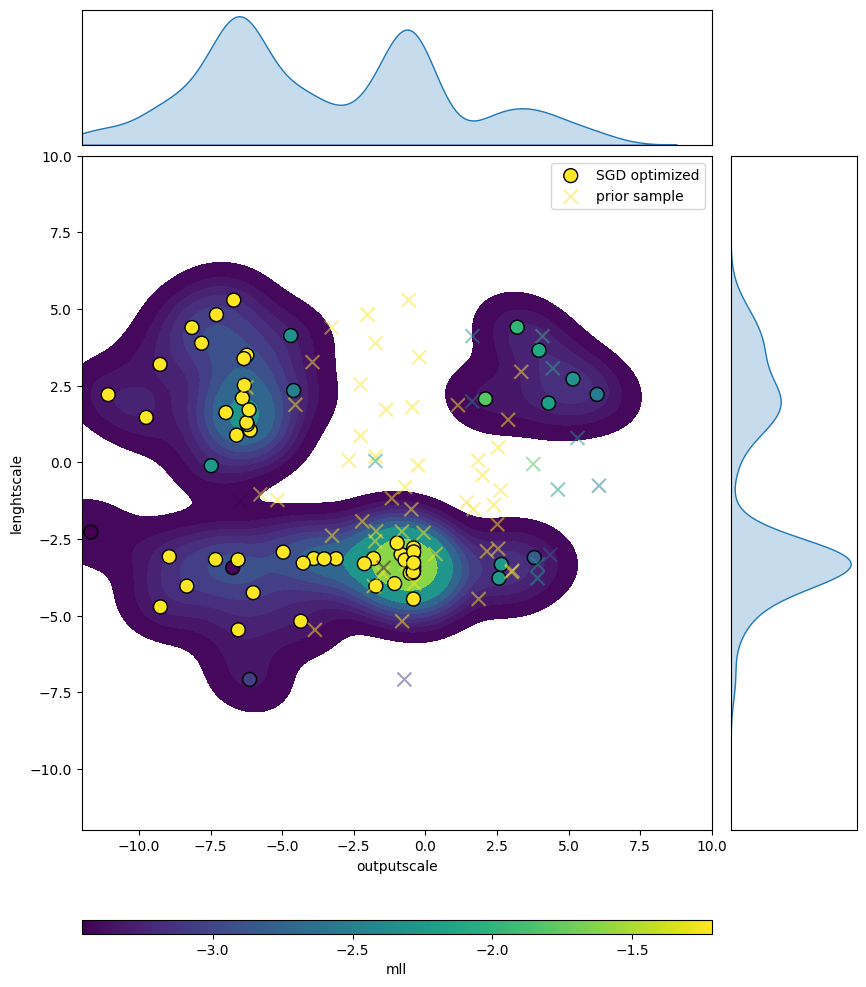

tensor([[-20.1056],
        [-22.1520],
        [-14.2357]], dtype=torch.float64)


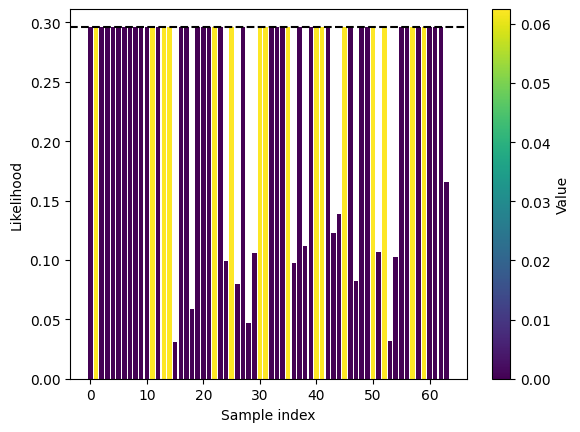

acq values
tensor([     nan,      nan,      nan,  ..., 212.8460,      nan, 215.2461],
       dtype=torch.float64, grad_fn=<SumBackward1>)
tensor([     nan,      nan,      nan,  ..., 213.3340,      nan, 220.0493],
       dtype=torch.float64, grad_fn=<SumBackward1>)
tensor([[[-18.8265],
         [-18.8265],
         [-18.8266],
         ...,
         [-18.8266],
         [-18.8266],
         [-18.8264]],

        [[-18.8311],
         [-18.8325],
         [-18.8340],
         ...,
         [-18.8311],
         [-18.8287],
         [-18.8311]],

        [[-18.8306],
         [-18.8306],
         [-18.8307],
         ...,
         [-18.8307],
         [-18.8307],
         [-18.8305]],

        ...,

        [[-18.8311],
         [-18.8311],
         [-18.8311],
         ...,
         [-18.8311],
         [-18.8311],
         [-18.8311]],

        [[-18.8290],
         [-18.8290],
         [-18.8290],
         ...,
         [-18.8290],
         [-18.8290],
         [-18.8290]],

        [[-

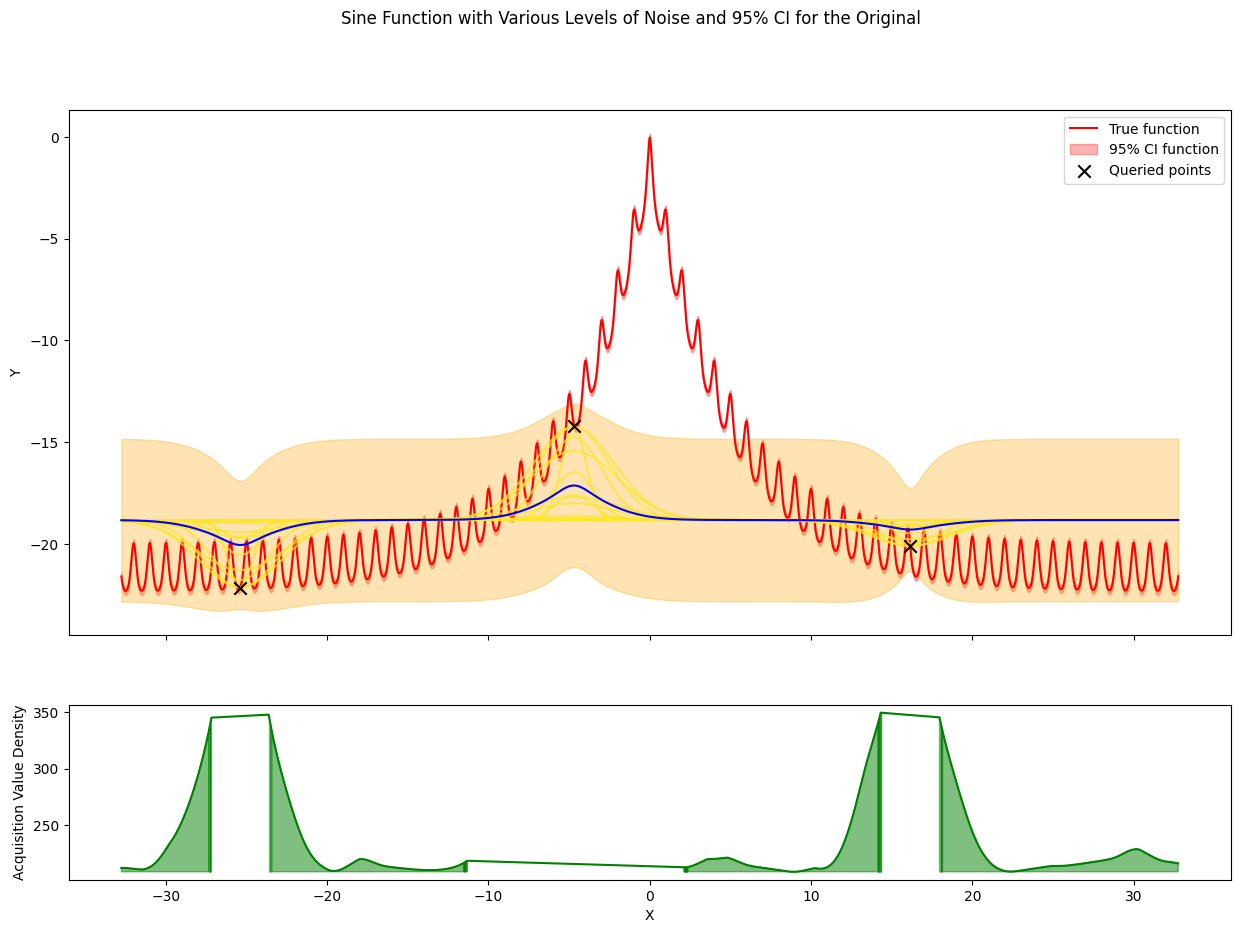

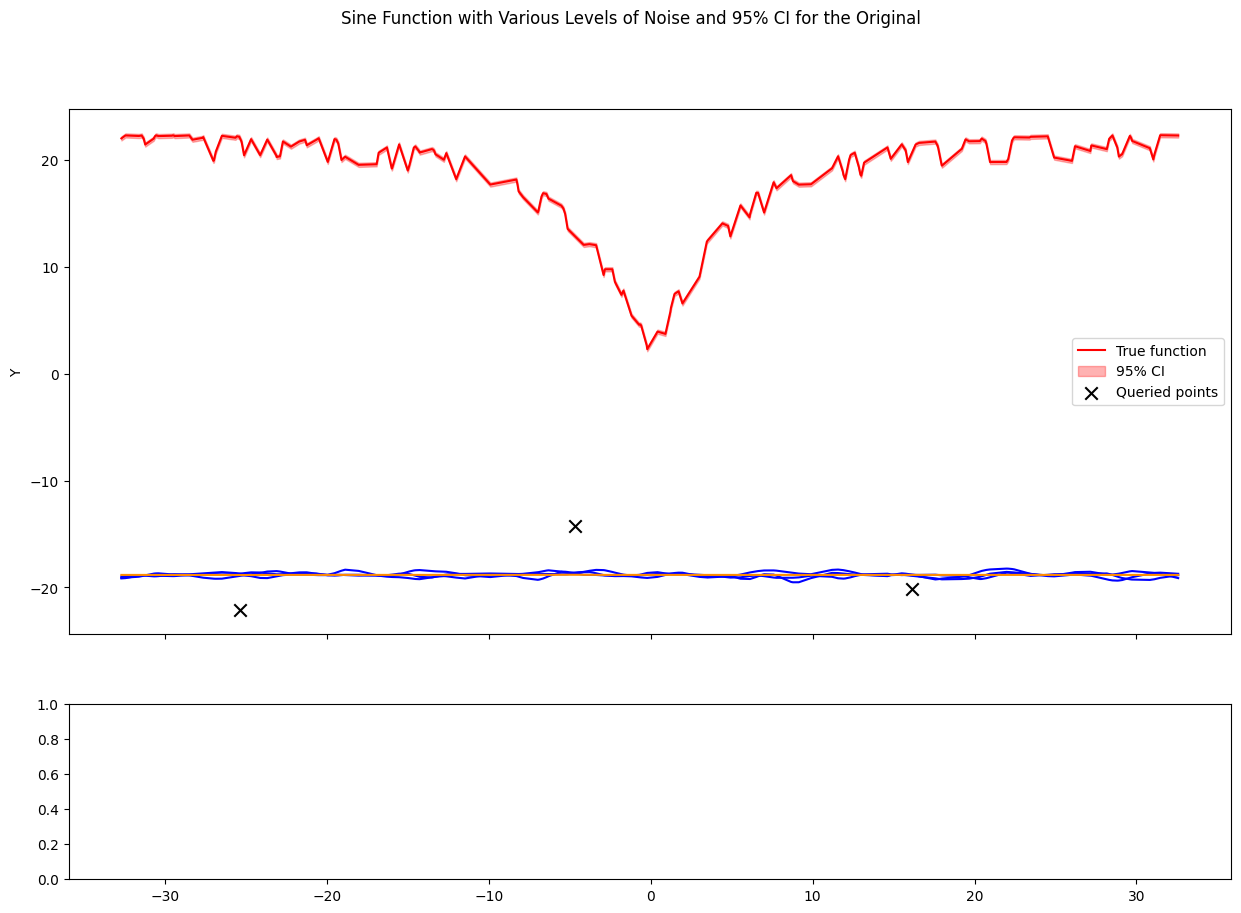

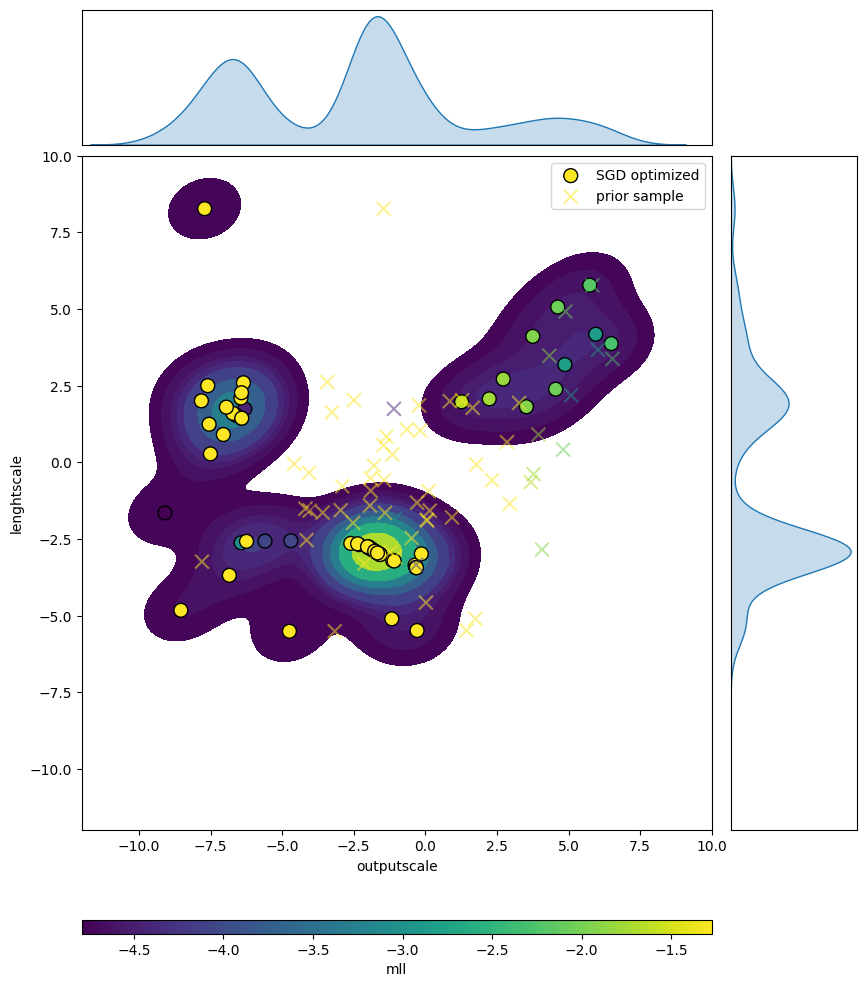

tensor([[-20.1056],
        [-22.1520],
        [-14.2357],
        [ -2.5617]], dtype=torch.float64)


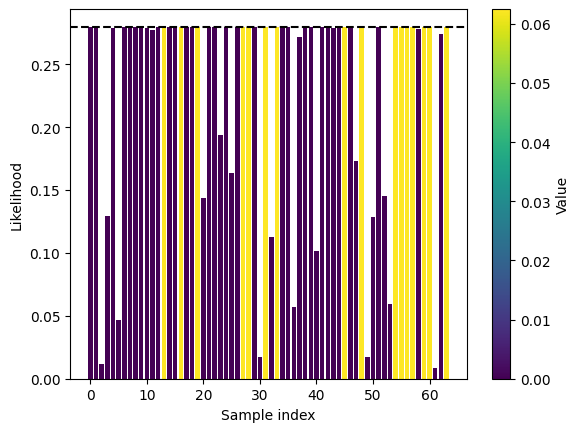

acq values
tensor([512.0298, 539.6887, 596.1037,  ..., 334.1621, 365.7264, 336.2404],
       dtype=torch.float64, grad_fn=<SumBackward1>)
tensor([653.3127, 508.1034, 531.8189,  ..., 319.8912, 362.0612, 332.2352],
       dtype=torch.float64, grad_fn=<SumBackward1>)
tensor([[[-14.7637],
         [-14.7637],
         [-14.7637],
         ...,
         [-14.7637],
         [-14.7637],
         [-14.7637]],

        [[-12.7502],
         [-15.9692],
         [-16.3146],
         ...,
         [-15.1808],
         [-14.4499],
         [-15.0767]],

        [[-14.7637],
         [-14.7637],
         [-14.7637],
         ...,
         [-14.7637],
         [-14.7637],
         [-14.7637]],

        ...,

        [[-14.7637],
         [-14.7637],
         [-14.7637],
         ...,
         [-14.7637],
         [-14.7637],
         [-14.7637]],

        [[ -3.0181],
         [-19.6124],
         [-21.3044],
         ...,
         [-15.9783],
         [-17.0240],
         [-15.8280]],

        [[-

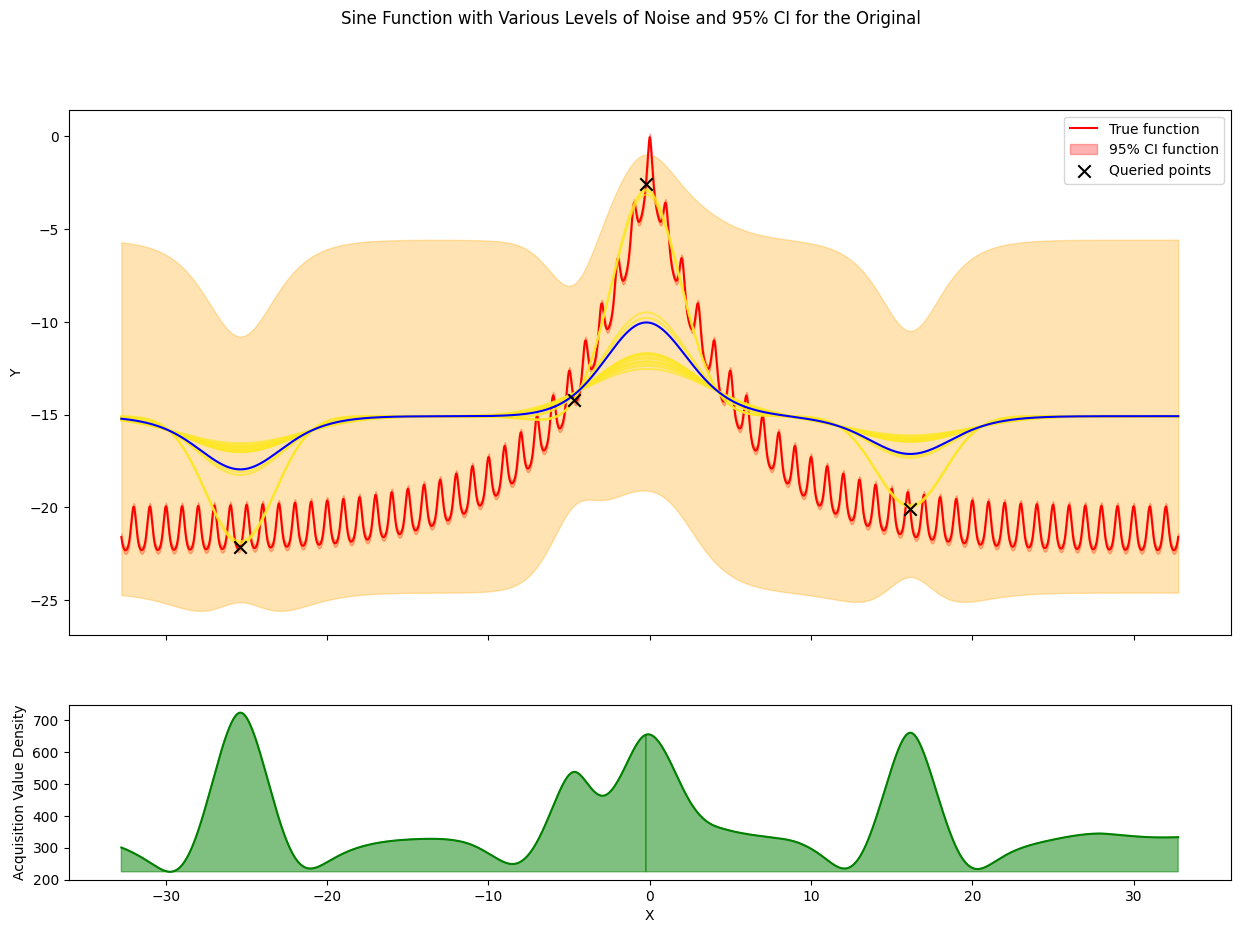

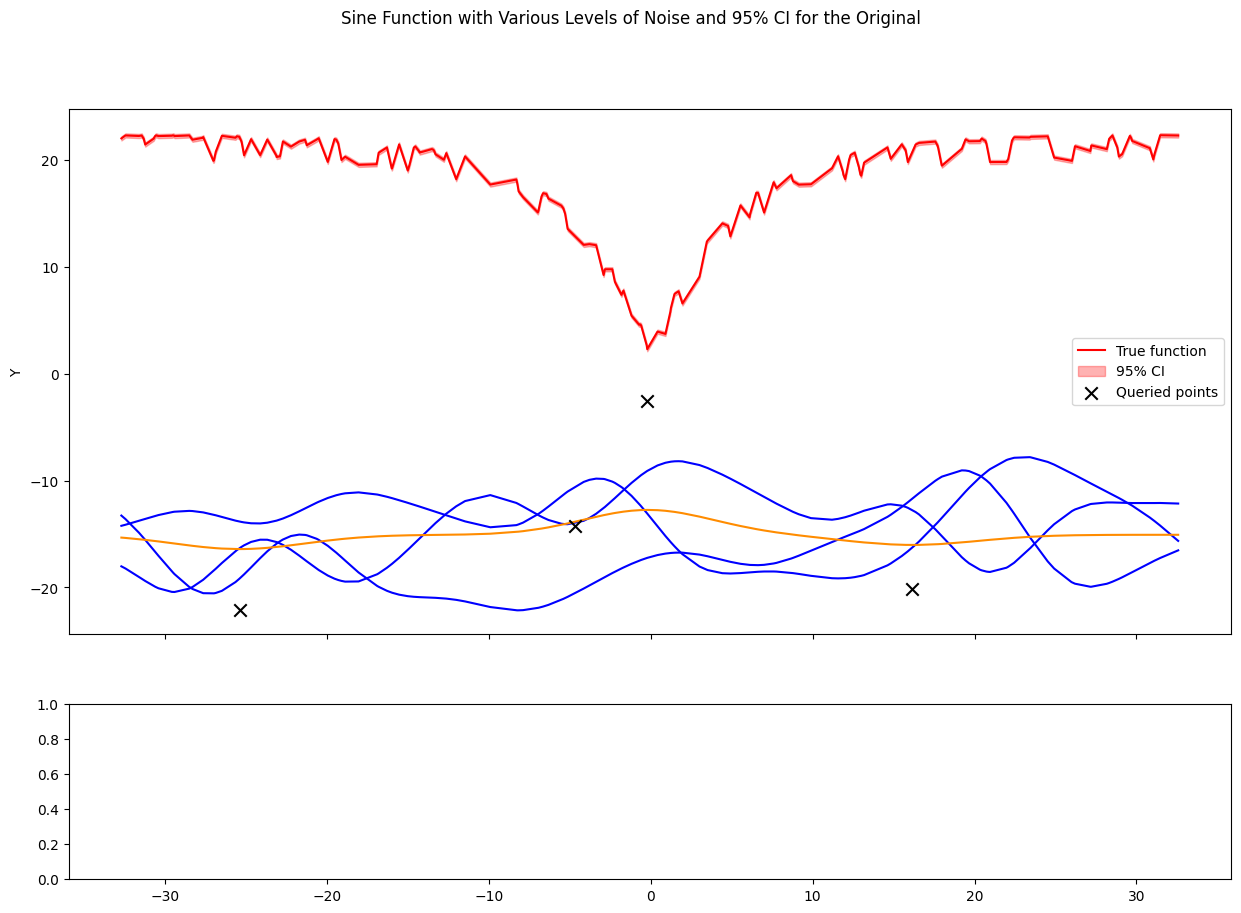

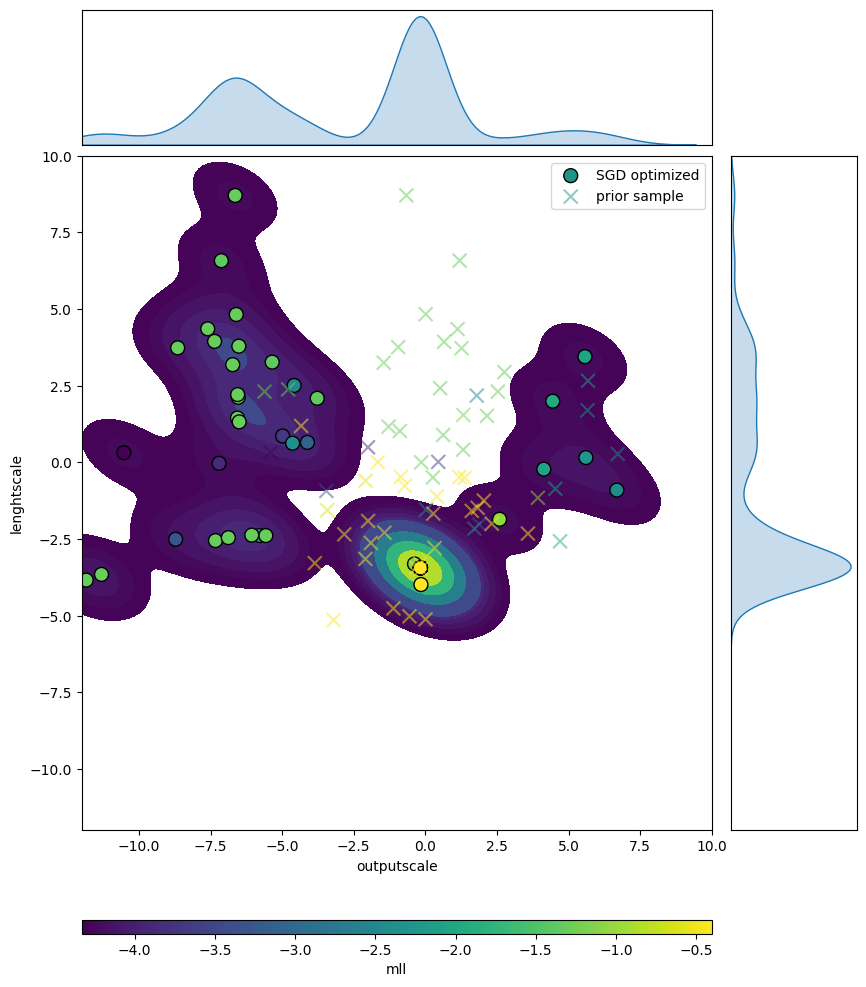

tensor([[-20.1056],
        [-22.1520],
        [-14.2357],
        [ -2.5617],
        [-22.1272]], dtype=torch.float64)


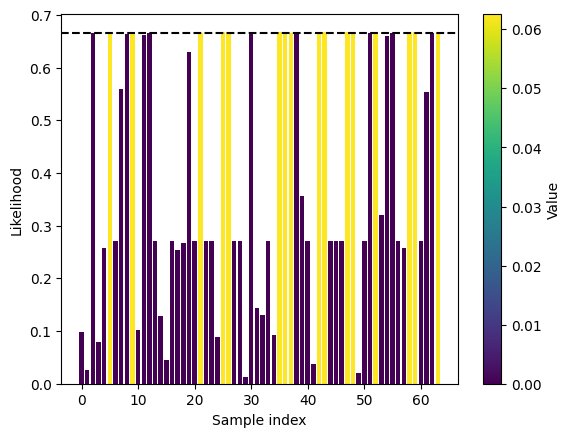

In [11]:
import matplotlib.pyplot as plt
preds_list = []
nmlls_list = []
#synthetic_function = Higdon(noise_std=0.1)
synthetic_function = botorch.test_functions.synthetic.Ackley(dim=DIM,noise_std=0.1, negate=NEGATE).to(**tkwargs)
bounds = BOUNDS
    #print(bounds)
X = SobolEngine(dimension=DIM, scramble=True, seed=55).draw(3).to(**tkwargs)
    #print(X)
X_scaled = convert_bounds(X, BOUNDS, DIM)
Y = synthetic_function(X_scaled).unsqueeze(-1)
Y_true = synthetic_function.evaluate_true(X_scaled).unsqueeze(-1)
if NEGATE:
    Y_true = -Y_true
poolU = get_candidate_pool(dim=DIM, bounds=BOUNDS, size=10000).to(**tkwargs)
ewig_pool = poolU.clone()
X_test, Y_test = get_test_set(synthetic_function=synthetic_function, 
                                  bounds=bounds, 
                                  dim=DIM, 
                                  noise_std=0.1,
                                  size=10000)  
X_test, Y_test = X_test.to(**tkwargs), Y_test.to(**tkwargs)
dict_best_params = None
for i in range(20):
    train_Y = Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        #input_transform=Normalize(d=cfg.functions.dim, bounds=bountensor_scaledds),
        outcome_transform=Standardize(m=1)
    )
    if type == 'part_bayesian':
        ll = fit_partially_bayesian_mgp_model(model=gp,
                                                num_samples= 64,
                                                lr=0.1,
                                                learning_steps=100,
                                                print_iter=False,
                                                plot=True, 
                                                dict_params=dict_best_params)
        dict_best_params = get_best_model_params(gp, ll=ll)
    else:
        ll = fit_fully_bayesian_mgp_model_nuts(gp,
                                            warmup_steps=256,
                                            num_samples=256 ,
                                            thinning=16,
                                            disable_progbar=False)
    print(Y)
    acq_function = ScoreBOWasserstein(gp, ll=ll)
    if ll is not None:
        ll = ll.detach()
        likelihoods = ll.exp()
        median_val = np.percentile(likelihoods, 75)
        #print(median_val)
        weights = torch.clone(likelihoods)
        weights[weights < median_val] = 0
        weights = weights.pow(1).squeeze().div(weights.pow(1).sum())
        npll = weights.numpy()
        norm = plt.Normalize(npll.min(), npll.max())
        colors = plt.cm.viridis(norm(npll))

    # Generate a sequence of colors from the 'viridis' colormap

    # Plotting
        plt.bar(range(len(npll)), likelihoods, color=colors)
        plt.ylabel('Likelihood')
        plt.xlabel('Sample index')
        plt.axhline(y=median_val, color='black', linestyle='--', label='percentile cut')
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), label='Value')
        plt.show()
    else:
        weights = ll

    acq_values = acq_function(poolU)
    print('acq values')
    print(acq_values)
    acq_values_all = acq_function(ewig_pool)
    print(acq_values_all)
    best_index = torch.argmax(acq_values)
    candidates = poolU[best_index].unsqueeze(-1)
    new_pool = torch.cat((poolU[:best_index], poolU[best_index + 1:]), dim=0)
    candidates, best_acq_value, poolU = candidates.T, acq_values[best_index].unsqueeze(-1), new_pool

    candidates_scaled = convert_bounds(candidates, BOUNDS, DIM)
    y_hat, y_mms, var_mms, Y_selecteds = get_yhat(gp, X_test, tkwargs, ll=ll)
    print(y_hat)
    plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y,acq_values_all,y_mms, var_mms, Y_selecteds, weights, mgp=True, negate=NEGATE)
    path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([3]))
    reduced_X_test = X_test[:200]
    y_hat,_,var_mms, _= get_yhat(gp, reduced_X_test, tkwargs, ll=ll)
    plot_samples_gp(reduced_X_test, 0.1, synthetic_function, y_hat,path(reduced_X_test),1, X, Y)
    Y_next = synthetic_function(candidates_scaled).unsqueeze(-1)
    Y_next_true = synthetic_function.evaluate_true(candidates_scaled).unsqueeze(-1)
    if NEGATE:
        Y_next_true = -Y_next_true
    if DIM ==10:
        Y_next=Y_next.unsqueeze(-1)
        Y_next_true=Y_next_true.unsqueeze(-1)
    nmll, rmse, preds = eval_new_mll(X_test, Y_test, X, train_Y, tkwargs)
    preds_list.append(preds)
    nmlls_list.append(nmll)
    Y = torch.cat((Y, Y_next)).to(**tkwargs)
    X = torch.cat((X, candidates)).to(**tkwargs)
    Y_true = torch.cat((Y_true, Y_next_true)).to(**tkwargs)
    plt.show()

In [25]:
gp.train_targets

tensor([-3.0222e-01,  1.4930e+00, -4.1370e+00,  6.2033e-02,  7.5329e-01,
        -1.5779e+00, -8.4723e-03,  2.4399e-01, -4.8596e-02, -9.0296e-02,
         1.9786e-02,  1.2264e-01,  5.0503e-01,  4.0265e-01,  2.9024e-01,
         2.9953e-01,  1.0848e-01, -7.1748e-02,  4.2256e-01,  3.6220e-01,
        -3.5459e-03,  5.4039e-01,  4.1167e-01,  1.9769e-01,  4.5111e-03],
       dtype=torch.float64)

In [ ]:
Y

tensor([[-20.2048],
        [-22.1137],
        [-14.0769],
        [ -2.6346]], dtype=torch.float64)

In [ ]:
plot_samples_gp(reduced_X_test, 0.1, synthetic_function, y_hat,path(reduced_X_test),10, X, Y)

IndexError: index 10 is out of bounds for dimension 1 with size 8

In [ ]:
ys = [y.numpy() for y in preds_list]

In [ ]:
X_test_scaled = convert_bounds(X_test, BOUNDS, DIM)

In [ ]:
x = X_test_scaled.detach().squeeze().numpy()

In [ ]:
x = X_test_scaled.detach().squeeze().numpy()

In [ ]:
df = pd.DataFrame({'x':x})

In [214]:
for i in range(0,len(ys)):
    if i%5 == 0:
        df['y_'+str(i)] = ys[i]


In [215]:
df = df.sort_values(by='x', ascending=True).reset_index(drop=True)

In [216]:
df

x       y_0       y_5      y_10      y_15      y_20      y_25  \
0     0.500159 -0.051048  0.127192  0.087583  0.100303  0.080154  0.168933   
1     0.500237 -0.051107  0.126930  0.087171  0.099974  0.079899  0.168883   
2     0.500297 -0.051152  0.126726  0.086851  0.099718  0.079701  0.168843   
3     0.500486 -0.051296  0.126086  0.085847  0.098916  0.079079  0.168720   
4     0.500596 -0.051380  0.125714  0.085263  0.098450  0.078718  0.168649   
...        ...       ...       ...       ...       ...       ...       ...   
9995  2.499615 -0.006349  5.062840  5.082332  5.064468  5.070780  4.994088   
9996  2.499634 -0.006349  5.062958  5.082463  5.064633  5.070975  4.994267   
9997  2.499671 -0.006349  5.063186  5.082719  5.064956  5.071355  4.994616   
9998  2.499676 -0.006349  5.063216  5.082752  5.064998  5.071405  4.994661   
9999  2.499887 -0.006349  5.064496  5.084185  5.066808  5.073542  4.996620   

          y_30      y_35      y_40      y_45      y_50      y_55      y_60  \
0     0.170868  0.157697  0.017452 -0.145439 -0.144121 -0.283240  0.096374   
1     0.170830  0.157692  0.017485 -0.145316 -0.143991 -0.282996  0.093596   
2     0.170800  0.157689  0.017511 -0.145221 -0.143890 -0.282807  0.091440   
3     0.170708  0.157678  0.017592 -0.144921 -0.143572 -0.282211  0.084681   
4     0.170654  0.157672  0.017639 -0.144746 -0.143388 -0.281865  0.080760   
...        ...       ...       ...       ...       ...       ...       ...   
9995  5.010513  4.999501  4.978844  4.967698  4.949631  4.958905  5.082096   
9996  5.010709  4.999694  4.979030  4.967876  4.949804  4.959028  5.082012   
9997  5.011092  5.000071  4.979392  4.968223  4.950142  4.959269  5.081847   
9998  5.011142  5.000120  4.979439  4.968269  4.950186  4.959300  5.081826   
9999  5.013290  5.002236  4.981471  4.970217  4.952082  4.960650  5.080891   

          y_65      y_70      y_75      y_80      y_85  
0     0.096408  0.096267  0.096125  0.096652  0.096925  
1     0.093629  0.093451  0.093300  0.093832  0.094098  
2     0.091472  0.091264  0.091107  0.091643  0.091903  
3     0.084711  0.084411  0.084233  0.084779  0.085023  
4     0.080788  0.080435  0.080244  0.080798  0.081031  
...        ...       ...       ...       ...       ...  
9995  5.082326  5.082349  5.082295  5.084184  5.085446  
9996  5.082243  5.082268  5.082215  5.084140  5.085386  
9997  5.082082  5.082111  5.082058  5.084053  5.085269  
9998  5.082061  5.082090  5.082038  5.084041  5.085254  
9999  5.081145  5.081194  5.081145  5.083541  5.084582  

[10000 rows x 19 columns]

In [217]:
x = df.x.values

In [218]:
new_ys = df.drop(['x'],axis=1).values.transpose()

In [219]:
def plot2din3d(x,y,z):
    ax.plot(x, y, zs=z, zdir='z')
    twod_col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1) 
    ax.add_collection3d(twod_col_obj, zs = z, zdir = 'z')

In [220]:
new_nmll_list = [nmlls_list[i].item() for i in range(len(nmlls_list)) if i%5==0]

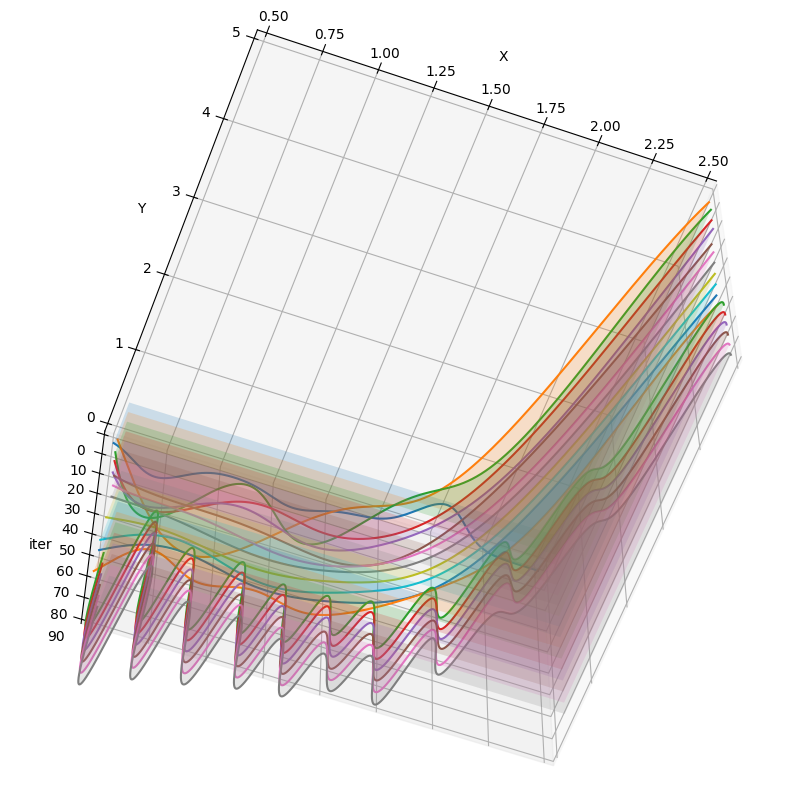

In [221]:
# Plot a sin curve using the x and y axes.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(projection='3d')
for z in range(0, len(new_ys)):
    x = x
    y = new_ys[z]
    plot2din3d(x, y, 5*(z+1))
#ax.legend()
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 5)
ax.set_zlim(0, len(ys))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("iter")
ax.view_init(elev=120., azim=-70)
ax.set_facecolor('white')  
plt.show()


C:\Users\felip\AppData\Local\Temp\ipykernel_22728\1927842011.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm_r')  # Choose a colormap


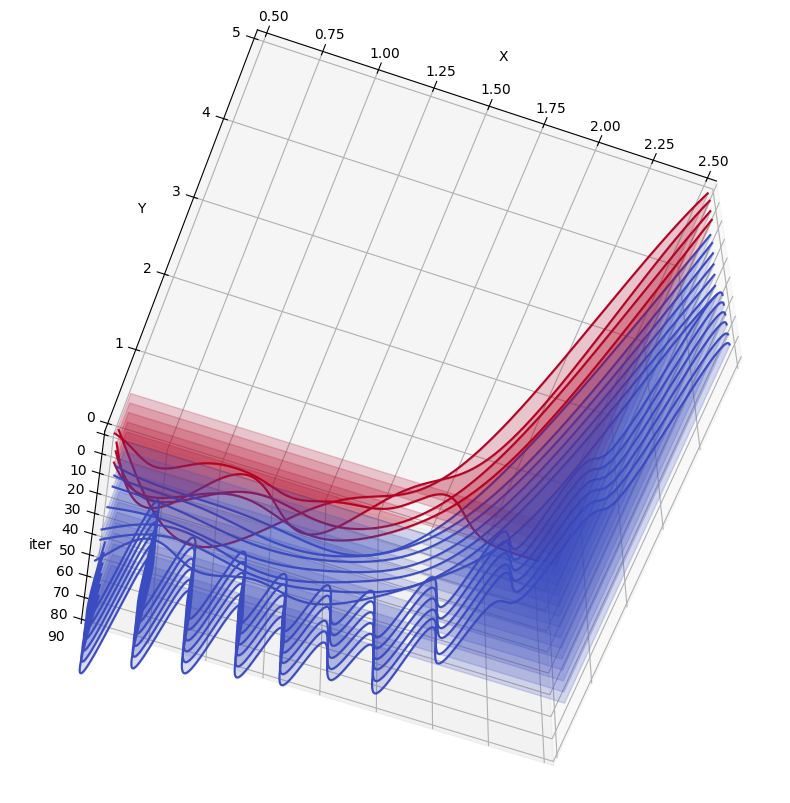

In [224]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Your plot2din3d function, modified to color the lines based on z value
def plot2din3d(x, y, z, color):
    line = ax.plot(x, y, zs=z, zdir='z', color=color)
    twod_col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1, color=color) 
    ax.add_collection3d(twod_col_obj, zs=z, zdir='z')

fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(projection='3d')

norm = mcolors.Normalize(vmin=min(np.log(np.array(new_nmll_list) +100)), vmax=max(np.log(np.array(new_nmll_list) +100)))
cmap = cm.get_cmap('coolwarm_r')  # Choose a colormap

# Plot each line with color based on z value
for z in range(0, len(new_ys)):
    x = x
    y = new_ys[z]
    color = cmap(norm(z))
    plot2din3d(x, y, 5*(z), color)
#ax.legend()

ax.set_xlim(0.5,2.5)
ax.set_ylim(0, 5)
ax.set_zlim(0, len(ys))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("iter")
ax.view_init(elev=120., azim=-70)
ax.set_facecolor('white')
plt.show()

In [204]:
# Putting the provided palette names into a Python list
palette_names = [
    'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
    'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 
    'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 
    'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 
    'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 
    'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 
    'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
    'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 
    'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 
    'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 
    'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 
    'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 
    'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 
    'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
    'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
    'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 
    'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r',
    'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 
    'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 
    'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
]

# Display the list to confirm it's correctly formatted
palette_names

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

Accent


C:\Users\felip\AppData\Local\Temp\ipykernel_22728\336365864.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(palette)  # Choose a colormap


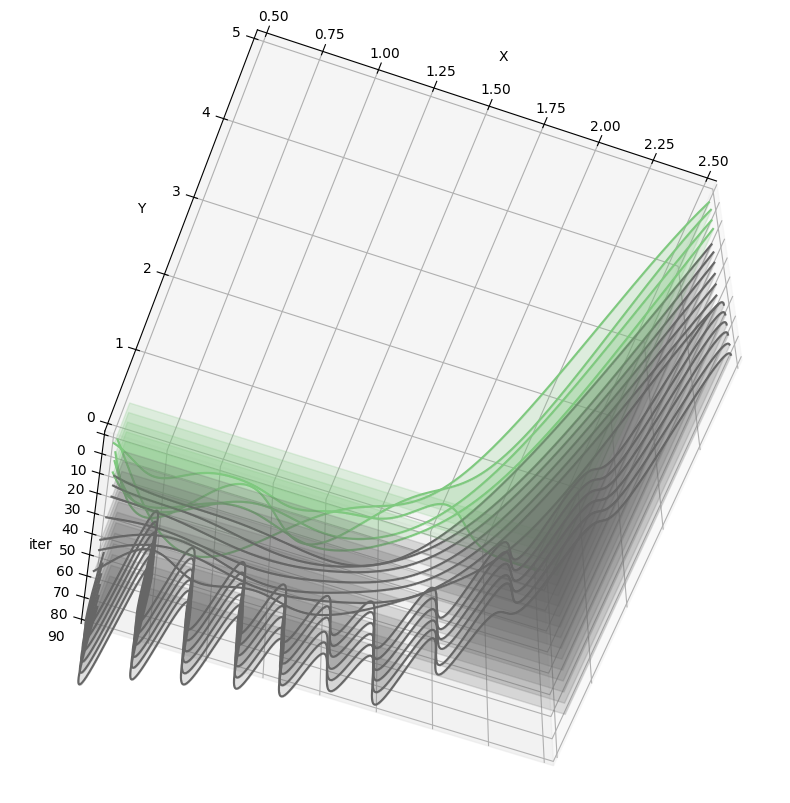

Accent_r


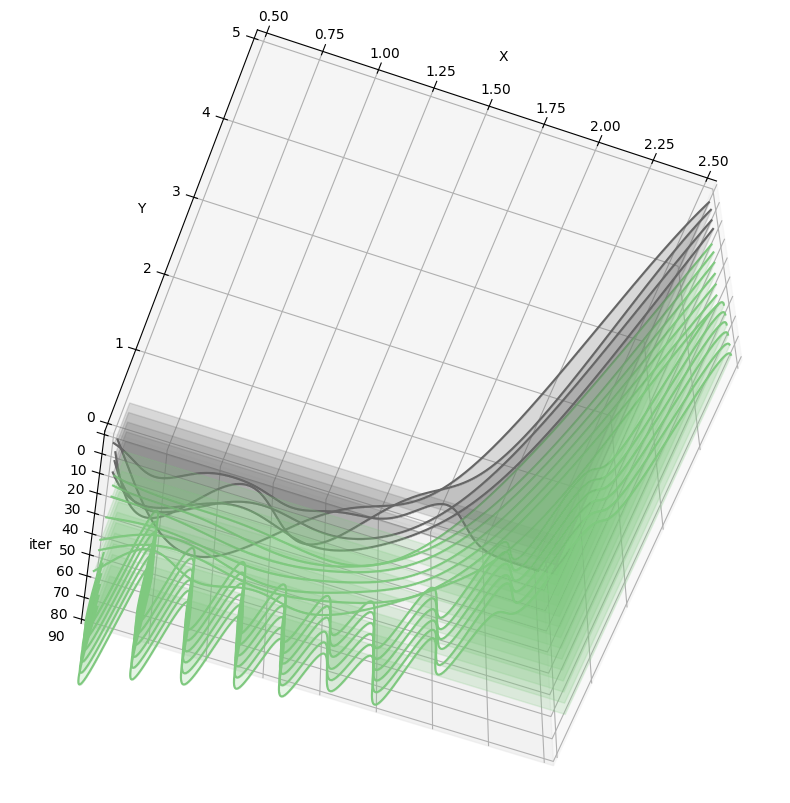

Blues


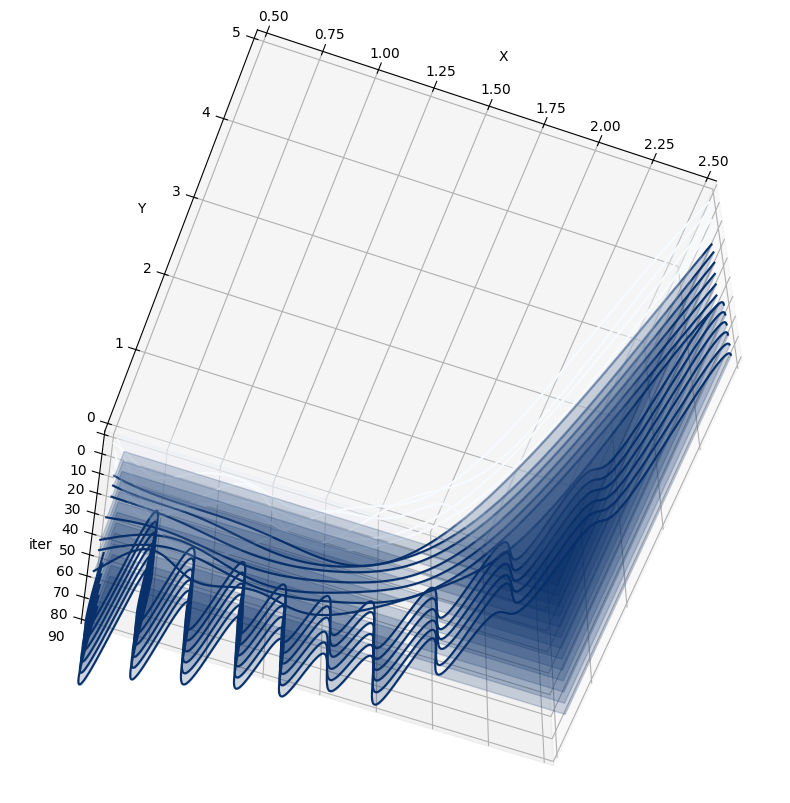

Blues_r


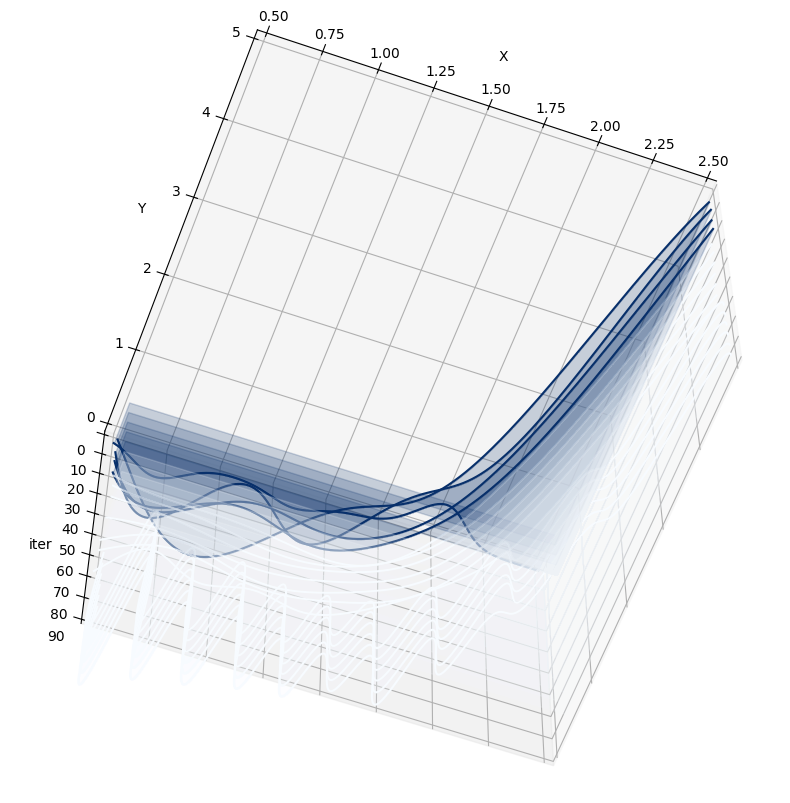

BrBG


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000019DC4A67100> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'Poly3DCollection' object has no attribute '_vec'

AttributeError: 'Poly3DCollection' object has no attribute '_vec'

<Figure size 1400x1000 with 1 Axes>

In [222]:
for palette in palette_names:
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    print(palette)
    # Your plot2din3d function, modified to color the lines based on z value
    def plot2din3d(x, y, z, color):
        line = ax.plot(x, y, zs=z, zdir='z', color=color)
        twod_col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1, color=color) 
        ax.add_collection3d(twod_col_obj, zs=z, zdir='z')

    fig = plt.figure(figsize=(14, 10))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(projection='3d')

    norm = mcolors.Normalize(vmin=min(np.log(np.array(new_nmll_list) +100)), vmax=max(np.log(np.array(new_nmll_list) +100)))
    cmap = cm.get_cmap(palette)  # Choose a colormap

    # Plot each line with color based on z value
    for z in range(0, len(new_ys)):
        x = x
        y = new_ys[z]
        color = cmap(norm(z))
        plot2din3d(x, y, 5*(z+1), color)
    #ax.legend()

    ax.set_xlim(0.5,2.5)
    ax.set_ylim(0, 5)
    ax.set_zlim(0, len(ys))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("iter")
    ax.view_init(elev=120., azim=-70)
    ax.set_facecolor('white')
    plt.show()

In [182]:
np.log(np.array(new_nmll_list) +10)

array([2.38547743, 2.06797828, 2.20967518, 2.21237879, 2.22080532,
       2.22122311, 2.22836223, 2.23719444, 2.2420052 , 2.24676234])

In [29]:
n_models


22

In [48]:
model=gp

posterior = model.posterior(ewig_pool, ll= ll)
n_models = posterior._mean.shape[MCMC_DIM]
model_dim = model.train_inputs[0].size()[1]
Grid = SobolEngine(dimension=model_dim, scramble=True, seed=99).draw(10000)#.to(**tkwargs)
Grid.size()
# num_optima = 3
# tnorm_mean, tnorm_var = get_truncated_moments(gp=model, grid=Grid,
#                                                           X=model.train_inputs[0], Y=model.train_targets,
#                                                           dim=model_dim, num_optima=num_optima)


# mean_minus_mgpmean = tnorm_mean - posterior.selected_mixture_mean.repeat(n_models,num_optima,1)
# BQBC = mean_minus_mgpmean.pow(2).mul(posterior.shaped_mask.repeat(1,num_optima,1)).sum(dim=MCMC_DIM).div(posterior.n_active_models)
# var = posterior.selected_variance.repeat(num_optima,1)
# mixture_variance = BQBC + var
# sigma_1 = mixture_variance.repeat(n_models,1,1)
# mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
# mu_1 = posterior.selected_mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
# sigma_2 = posterior.variance
# mu_2 = posterior.mean
# left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
# dif_means = mu_1-mu_2
# up = sigma_1 + dif_means.pow(2)
# KL = left + up.div(2*sigma_2) - 0.5
# KL.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)

torch.Size([10000, 1])

In [57]:
from botorch.utils.transforms import unnormalize
from typing import Any, Generator, Iterable, List, Optional, Tuple, TYPE_CHECKING
from botorch.sampling.pathwise.paths import SamplePath
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths

def optimize_posterior_samples(
    paths: SamplePath,
    bounds: Tensor,
    candidates: Optional[Tensor] = None,
    raw_samples: Optional[int] = 1024,
    num_restarts: int = 20,
    maximize: bool = True,
    **kwargs: Any,
) -> Tuple[Tensor, Tensor]:
    r"""Cheaply maximizes posterior samples by random querying followed by vanilla
    gradient descent on the best num_restarts points.

    Args:
        paths: Random Fourier Feature-based sample paths from the GP
        bounds: The bounds on the search space.
        candidates: A priori good candidates (typically previous design points)
            which acts as extra initial guesses for the optimization routine.
        raw_samples: The number of samples with which to query the samples initially.
        num_restarts: The number of points selected for gradient-based optimization.
        maximize: Boolean indicating whether to maimize or minimize

    Returns:
        A two-element tuple containing:
            - X_opt: A `num_optima x [batch_size] x d`-dim tensor of optimal inputs x*.
            - f_opt: A `num_optima x [batch_size] x 1`-dim tensor of optimal outputs f*.
    """
    if maximize:

        def path_func(x):
            return paths(x)

    else:

        def path_func(x):
            return -paths(x)

    candidate_set = unnormalize(
        SobolEngine(dimension=bounds.shape[1], scramble=True).draw(raw_samples), bounds
    )

    # queries all samples on all candidates - output shape
    # raw_samples * num_optima * num_models
    candidate_queries = path_func(candidate_set)
    argtop_k = torch.topk(candidate_queries, num_restarts, dim=-1).indices
    X_top_k = candidate_set[argtop_k, :]

    # to avoid circular import, the import occurs here
    from botorch.generation.gen import gen_candidates_torch

    X_top_k, f_top_k = gen_candidates_torch(
        X_top_k, path_func, lower_bounds=bounds[0], upper_bounds=bounds[1], **kwargs
    )
    f_opt, arg_opt = f_top_k.max(dim=-1, keepdim=True)

    # For each sample (and possibly for every model in the batch of models), this
    # retrieves the argmax. We flatten, pick out the indices and then reshape to
    # the original batch shapes (so instead of pickig out the argmax of a
    # (3, 7, num_restarts, D)) along the num_restarts dim, we pick it out of a
    # (21  , num_restarts, D)
    final_shape = candidate_queries.shape[:-1]
    X_opt = X_top_k.reshape(final_shape.numel(), num_restarts, -1)[
        torch.arange(final_shape.numel()), arg_opt.flatten()
    ].reshape(*final_shape, -1)
    if not maximize:
        f_opt = -f_opt
    return X_opt, f_opt

In [58]:
def get_optimal_samples(
    model: Model,
    bounds: Tensor,
    num_optima: int,
    raw_samples: int = 1024,
    num_restarts: int = 20,
    maximize: bool = True,
) -> Tuple[Tensor, Tensor]:
    """Draws sample paths from the posterior and maximizes the samples using GD.

    Args:
        model (Model): The model from which samples are drawn.
        bounds: (Tensor): Bounds of the search space. If the model inputs are
            normalized, the bounds should be normalized as well.
        num_optima (int): The number of paths to be drawn and optimized.
        raw_samples (int, optional): The number of candidates randomly sample.
            Defaults to 1024.
        num_restarts (int, optional): The number of candidates to do gradient-based
            optimization on. Defaults to 20.
        maximize: Whether to maximize or minimize the samples.
    Returns:
        Tuple[Tensor, Tensor]: The optimal input locations and corresponding
        outputs, x* and f*.

    """
    paths = draw_matheron_paths(model, sample_shape=torch.Size([num_optima]))
    optimal_inputs, optimal_outputs = optimize_posterior_samples(
        paths,
        bounds=bounds,
        raw_samples=raw_samples,
        num_restarts=num_restarts,
        maximize=maximize,
    )
    return optimal_inputs, optimal_outputs

In [59]:
num_optima=8

In [60]:
torch.tensor([[0],[1]]).repeat(1,2)

tensor([[0, 0],
        [1, 1]])

In [61]:
opt_inputs, opt_outputs = get_optimal_samples(model=gp,bounds=torch.tensor([[0],[1]]), num_optima=num_optima)

In [62]:
def normal_to_truncnorm(all_means, all_vars, all_maxs):
    #https://en.wikipedia.org/wiki/Truncated_normal_distribution
    Norm = torch.distributions.normal.Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
    pdf_betas=Norm.log_prob(all_maxs).exp()
    cdf_betas = Norm.cdf(all_maxs)
    tnorm_mean = all_means -torch.sqrt(all_vars)*pdf_betas.div(cdf_betas)
    right = pdf_betas.div(cdf_betas)
    right = right.pow(2)
    left = all_maxs*pdf_betas.div(cdf_betas) 
    tnorm_var = 1-left-right
    tnorm_var = all_vars*tnorm_var
    return tnorm_mean, tnorm_var

def get_truncated_moments(gp, X_to_condition_complete,Y_to_condition_complete, X, Y, X_test, num_optima=3):
    # path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([num_optima]))
    # samples =path(grid)
    n_models = X_to_condition_complete.size()[1]
    X_test_size = X_test.size()[0]
    model_dim = X.size()[1]
    # max_obj = samples.max(dim=2)
    # maximun_index = max_obj[1]
    # maximuns = max_obj[0]
    # X_to_condition_complete = grid[maximun_index]
    list_means, list_variances = [], []
    for index in range(num_optima):
        X_to_condition= X_to_condition_complete[index, :,:].unsqueeze(1)
        Y_to_condition = Y_to_condition_complete[index]
        X_with_new_max = torch.cat([X.repeat(n_models,1,1), X_to_condition], dim=1)
        Y_with_new_max = torch.cat([Y.repeat(n_models,1,1).squeeze(), Y_to_condition], dim=1)
        batch_gp = BatchGPModel(X_with_new_max,
                Y_with_new_max,
                dimensions=model_dim,
                batch_size=n_models)
        batch_gp.load_params(gp.get_param_dict())
        batch_gp.eval()
        batch_gp.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = batch_gp.likelihood(batch_gp(X_test))
            list_means.append(predictions.mean.unsqueeze(-1))
            list_variances.append(predictions.variance.unsqueeze(-1))
    all_means = torch.cat(list_means, -1).swapaxes(-1,1)
    print('all_means')
    print(all_means)
    all_vars = torch.cat(list_variances, -1).swapaxes(-1,1)
    all_maxs = Y_to_condition_complete.repeat(1,1,X_test_size).detach().swapaxes(0,1)
    tnorm_mean, tnorm_var = normal_to_truncnorm(all_means, all_vars, all_maxs)
    return tnorm_mean.swapaxes(-1,-2), tnorm_var.swapaxes(-1,-2)

In [63]:
opt_inputs

tensor([[[0.0000],
         [1.0000],
         [0.5349],
         [0.0000],
         [1.0000],
         [1.0000],
         [0.5042],
         [1.0000],
         [1.0000],
         [0.0000],
         [0.5027],
         [1.0000],
         [0.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [0.2225],
         [0.0000],
         [1.0000],
         [0.0000],
         [1.0000],
         [0.4738],
         [0.5555],
         [0.4631],
         [0.0000],
         [0.0000],
         [1.0000],
         [0.0000],
         [0.4991],
         [0.4917],
         [0.1944]],

        [[0.3691],
         [0.0000],
         [0.5097],
         [1.0000],
         [0.0000],
         [0.8942],
         [0.5565],
         [0.0000],
         [0.2960],
         [1.0000],
         [0.2159],
         [1.0000],
         [0.0000],
         [0.0000],
         [1.0000],
         [0.0000],
         [0.2461],
         [0.6363],
         [1.0000],
         [0.0000],
         [

In [49]:
num_optima = 3

In [50]:
tnorm_mean, tnorm_var = get_truncated_moments(gp=gp,
                       X_to_condition_complete=opt_inputs,
                       Y_to_condition_complete=opt_outputs,
                        X=X,
                        Y=Y, 
                        X_test=X_test, 
                        num_optima=num_optima)

NameError: name 'opt_inputs' is not defined

In [47]:
tnorm_mean

NameError: name 'tnorm_mean' is not defined

In [ ]:
tnorm_mean.size()

torch.Size([44, 10000, 8])

In [ ]:
torch.tensor([[0,0],[1,1]]).size(1)

2

In [ ]:
n_models=44

In [13]:
posterior.n_active_models

NameError: name 'posterior' is not defined

In [ ]:
posterior = gp.posterior(X_test, ll= ll)
n_models = posterior._mean.shape[MCMC_DIM]
model_dim = model.train_inputs[0].size()[1]
mean_minus_mgpmean = tnorm_mean - posterior.selected_mixture_mean.unsqueeze(0).repeat(n_models,1,num_optima)
BQBC = mean_minus_mgpmean.pow(2).mul(posterior.shaped_mask.repeat(1,1,num_optima)).sum(dim=MCMC_DIM).div(posterior.n_active_models)
var = posterior.selected_variance.repeat(1,num_optima)
mixture_variance = BQBC + var
sigma_1 = mixture_variance.repeat(n_models,1,1)
mu_1 = posterior.selected_mixture_mean.repeat(n_models,1,num_optima)
sigma_2 = tnorm_var
mu_2 = tnorm_mean
left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
dif_means = mu_1-mu_2
up = sigma_1 + dif_means.pow(2)
KL = left + up.div(2*sigma_2) - 0.5
KL =KL.mul(posterior.shaped_weights.repeat(1,1,num_optima)).sum(dim=MCMC_DIM).sum(dim=-1)

In [ ]:
KL.size()

torch.Size([10000])

In [ ]:
MCMC_DIM

-3

In [ ]:
tnorm_mean.size()
posterior.selected_mixture_mean.unsqueeze(0).repeat(n_models,1,num_optima).size()

torch.Size([44, 10000, 3])

In [102]:
posterior.shaped_mask.repeat(1,1,num_optima).size()

torch.Size([32, 10000, 3])

In [18]:
class BatchGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, dimensions,  batch_size, likelihood):
        #likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([batch_size]))
        super(BatchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([batch_size]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=dimensions, 
                                       batch_shape=torch.Size([batch_size])),
            batch_shape=torch.Size([batch_size])
        )
    
    def forward(self, x):
        # x is expected to be of shape [batch size, number of data points, features]
        # Ensure that the kernel can handle multidimensional input properly
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def load_params(self, param_dict):
        # self.covar_module.base_kernel.lengthscale = param_dict['lengthscale']
        # self.covar_module.outputscale = param_dict['outputscale']
        # self.mean_module.constant = param_dict['mean']
        # self.likelihood.noise_covar.noise = param_dict['noise']
        
        new_state_dict = {}
        new_state_dict['likelihood.noise_covar.raw_noise'] = param_dict['noise']
        new_state_dict['mean_module.raw_constant'] = param_dict['mean']
        new_state_dict['covar_module.raw_outputscale'] = param_dict['outputscale']
        new_state_dict['covar_module.base_kernel.raw_lengthscale'] = param_dict['lengthscale']
        self.load_state_dict(new_state_dict)

    def condition_on_data(self, X, y):
        self.set_train_data(inputs=X, targets=y, strict=False)

    def load_params_new(self, param_dict):
        self.covar_module.base_kernel.lengthscale = param_dict['lengthscale']
        self.covar_module.outputscale = param_dict['outputscale']
        self.mean_module.constant = param_dict['mean']
        self.likelihood.noise_covar.noise = param_dict['noise']


In [42]:
gp.likelihood

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [19]:
path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([3]))

In [20]:
samples =path(X_test[:10000])

In [21]:
max_obj = samples.max(dim=2)
#del samples 
maximun_index = max_obj[1]
maximuns = max_obj[0]

In [22]:
X_to_condition_complete = X_test[maximun_index]

In [23]:
torch.round(X_to_condition_complete, decimals=3)

tensor([[[0.0000],
         [1.0000],
         [0.0000],
         [1.0000],
         [1.0000],
         [0.6580],
         [1.0000],
         [0.0000],
         [0.5720],
         [0.0000],
         [1.0000],
         [0.0000],
         [0.0000],
         [0.0200],
         [0.1490],
         [1.0000]],

        [[1.0000],
         [0.0000],
         [0.5780],
         [1.0000],
         [0.8830],
         [0.0000],
         [0.0670],
         [0.7890],
         [0.9140],
         [1.0000],
         [0.0000],
         [1.0000],
         [0.0510],
         [0.9630],
         [0.0000],
         [1.0000]],

        [[0.9510],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [0.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [0.0000],
         [1.0000],
         [0.0000],
         [0.7260],
         [0.0000],
         [0.0000],
         [0.8050]]], dtype=torch.float64)

In [24]:
X_to_condition_complete.size()

torch.Size([3, 16, 1])

In [25]:
index = 0
X_to_condition= X_to_condition_complete[index, :,:].unsqueeze(1)

In [26]:
Y_to_condition = maximuns[index].unsqueeze(1)

In [27]:
Y_to_condition.size()

torch.Size([16, 1])

In [28]:
X_with_new_max = torch.cat([X.repeat(16,1,1), X_to_condition], dim=1)
Y_with_new_max = torch.cat([Y.repeat(16,1,1).squeeze(), Y_to_condition], dim=1)

In [29]:
Y_with_new_max

tensor([[ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  1.7285],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  1.2840],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  2.7093],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  1.9872],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  1.1820],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  0.9256],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.6012,  1.4002],
        [ 0.5395,  1.0632, -0.9453,  0.6831,  0.7367, -0.0994,  0.4909,  0.6365,
          0.8110,  0.6344,  0.

In [30]:
batch_gp = BatchGPModel(None,
             None,
             dimensions=DIM,
             batch_size=16, likelihood=gp.likelihood)
batch_gp.condition_on_data(X_with_new_max, Y_with_new_max)
#batch_gp.load_params(gp.get_param_dict())
batch_gp.load_params_new(gp.get_param_dict())

In [31]:
maxs = maximuns[index].unsqueeze(1).repeat(1, 10000).detach()

In [32]:
batch_gp.eval()
batch_gp.likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # The test data is wrapped in a torch.no_grad() context
    # to indicate that we do not need gradients
    # gpytorch.settings.fast_pred_var() is used to speed up predictions
 # Add batch dimension if your model expects it
    predictions = batch_gp.likelihood(batch_gp(X_test))

    # Extract mean and variance
    means = predictions.mean
    variances = predictions.variance

In [33]:
means

tensor([[-0.4473,  0.5001,  0.9593,  ...,  0.0808, -0.4637,  0.6807],
        [-0.2959,  0.4854,  0.4873,  ...,  0.0236, -0.2972,  0.9253],
        [-0.5248,  0.5342,  1.3481,  ...,  0.0656, -0.6014,  0.5472],
        ...,
        [-0.4053,  0.4965,  0.7880,  ...,  0.0649, -0.4170,  0.6882],
        [-0.4851,  0.4890,  1.2169,  ...,  0.3794, -0.3821,  0.6987],
        [-0.5022,  0.4675,  0.5773,  ...,  0.0263, -0.4278,  1.4462]],
       dtype=torch.float64)

In [34]:
gp.get_param_dict()

{'noise': tensor([[2.8376],
         [2.8376],
         [2.8401],
         [2.8358],
         [2.8366],
         [2.8420],
         [2.8360],
         [2.8371],
         [2.8366],
         [2.8374],
         [3.0003],
         [2.9620],
         [2.8377],
         [2.8355],
         [2.8348],
         [2.8371]], dtype=torch.float64),
 'lengthscale': tensor([[[ 0.2638]],
 
         [[ 0.3007]],
 
         [[ 0.2104]],
 
         [[ 0.3521]],
 
         [[ 0.2939]],
 
         [[ 0.3888]],
 
         [[ 0.2446]],
 
         [[ 0.3421]],
 
         [[ 0.3356]],
 
         [[ 0.3158]],
 
         [[11.9676]],
 
         [[ 2.1070]],
 
         [[ 0.3063]],
 
         [[ 0.2679]],
 
         [[ 0.2573]],
 
         [[ 0.3022]]], dtype=torch.float64),
 'outputscale': tensor([7.4365, 5.9437, 6.5700, 5.6253, 7.2065, 5.3502, 7.3045, 6.6878, 6.1782,
         8.4035, 7.4102, 6.0993, 7.5733, 7.0995, 8.4763, 7.7020],
        dtype=torch.float64),
 'mean': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [35]:
# Print model's state dictionary (includes hyperparameters)
for param_tensor in batch_gp.state_dict():
    print(f"{param_tensor}: {batch_gp.state_dict()[param_tensor]}")

likelihood.noise_covar.raw_noise: tensor([[2.7771],
        [2.7771],
        [2.7798],
        [2.7752],
        [2.7761],
        [2.7818],
        [2.7754],
        [2.7766],
        [2.7760],
        [2.7769],
        [2.9491],
        [2.9088],
        [2.7773],
        [2.7749],
        [2.7742],
        [2.7767]], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound: 9.999999747378752e-05
likelihood.noise_covar.raw_noise_constraint.upper_bound: inf
mean_module.raw_constant: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
covar_module.raw_outputscale: tensor([7.4359, 5.9411, 6.5686, 5.6217, 7.2058, 5.3454, 7.3038, 6.6865, 6.1761,
        8.4033, 7.4095, 6.0971, 7.5728, 7.0987, 8.4761, 7.7016])
covar_module.base_kernel.raw_lengthscale: tensor([[[-1.1978]],

        [[-1.0476]],

        [[-1.4519]],

        [[-0.8626]],

        [[-1.0739]],

        [[-0.7439]],

        [[-1.2833]],

        [[-0.8969]],

        [[-0.9195]],

  

In [40]:
chosen_go_index = 13

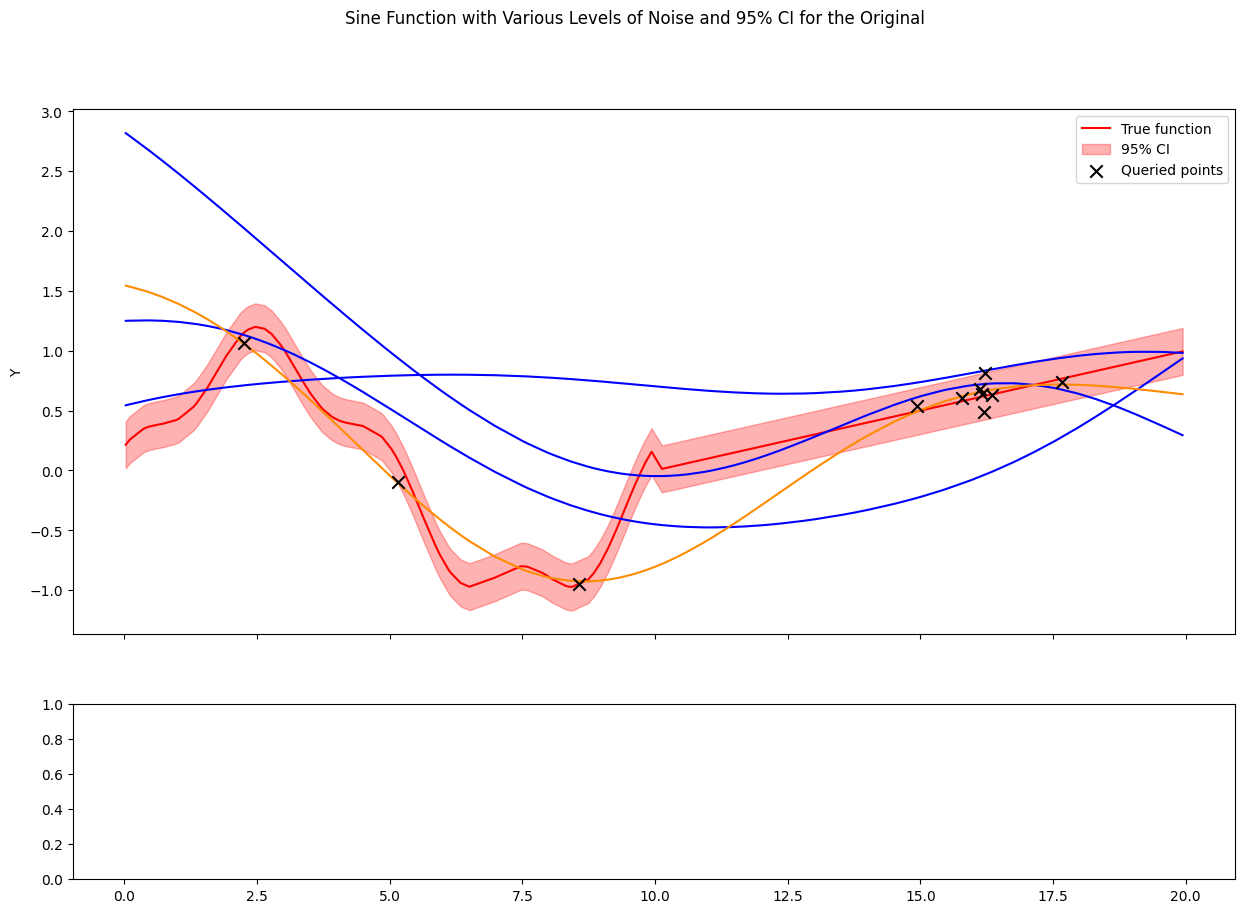

In [41]:
plot_samples_gp(reduced_X_test, 0.1, synthetic_function, y_hat,path(reduced_X_test),chosen_go_index, X, Y)

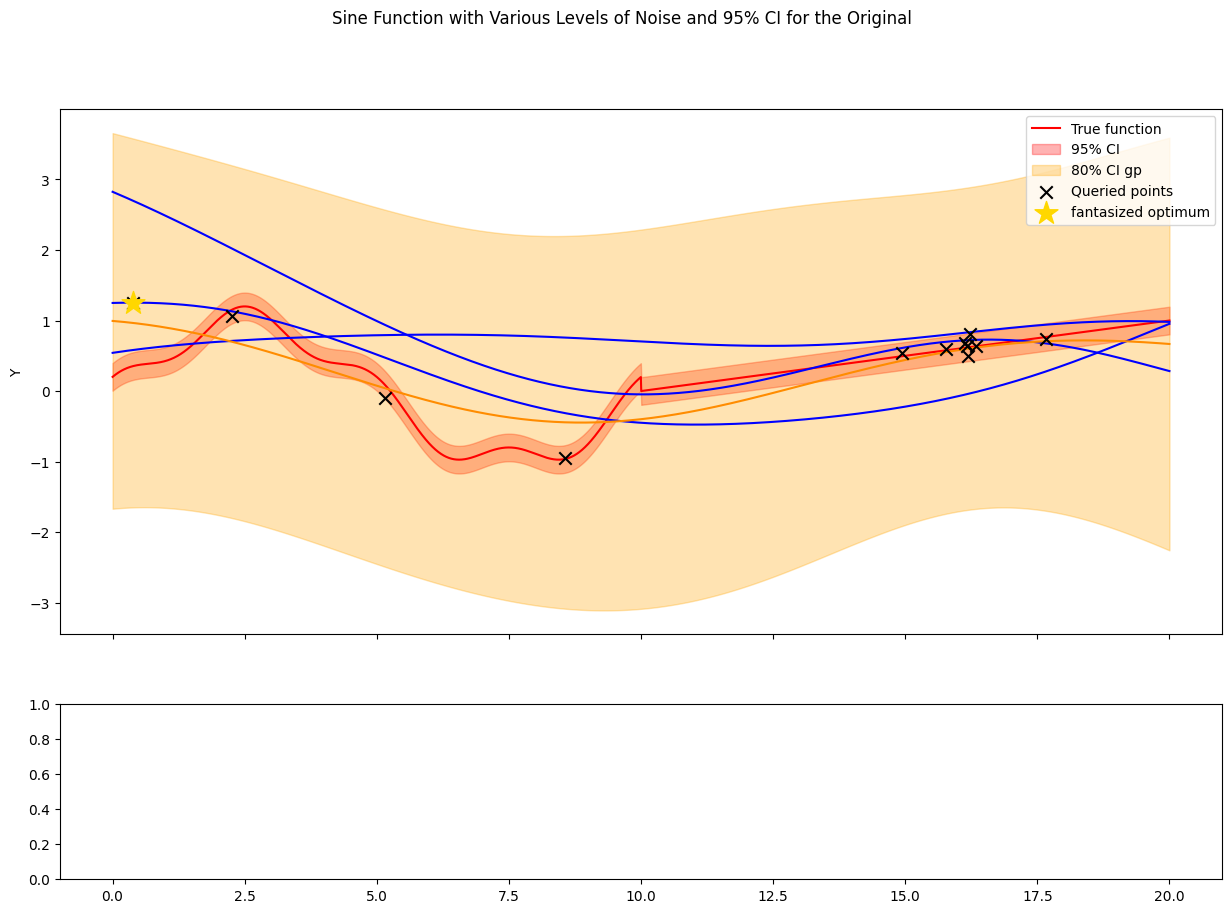

In [42]:
plot_samples_gp(X_test, 0.1, synthetic_function, means,samples,chosen_go_index, X_with_new_max[chosen_go_index], Y_with_new_max[chosen_go_index], variances, last=True)

In [404]:
X_with_new_max.size()

torch.Size([32, 9, 1])

In [43]:
Norm = torch.distributions.normal.Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
#https://en.wikipedia.org/wiki/Truncated_normal_distribution
maxs = maxs-means
maxs = maxs/torch.sqrt(variances)
pdf_betas=Norm.log_prob(maxs).exp()
cdf_betas = Norm.cdf(maxs)
tnorm_mean = means -torch.sqrt(variances)*pdf_betas.div(cdf_betas)
print(variances*pdf_betas.div(cdf_betas))
right = pdf_betas.div(cdf_betas)
right = right.pow(2)
left = maxs*pdf_betas.div(cdf_betas) 
tnorm_var = 1-left-right
tnorm_var = variances*tnorm_var

tensor([[1.2300, 1.3729, 2.1967,  ..., 1.3940, 1.1047, 2.6038],
        [1.5242, 1.7294, 2.5007,  ..., 1.6825, 1.4856, 2.5859],
        [0.6925, 0.7318, 1.6570,  ..., 0.7709, 0.5159, 1.6746],
        ...,
        [1.6308, 1.7919, 2.5111,  ..., 1.7814, 1.5032, 3.1155],
        [1.0331, 1.1194, 2.3268,  ..., 1.2971, 0.9701, 2.4326],
        [0.6184, 0.7881, 1.4768,  ..., 0.7961, 0.6235, 1.9163]],
       dtype=torch.float64)


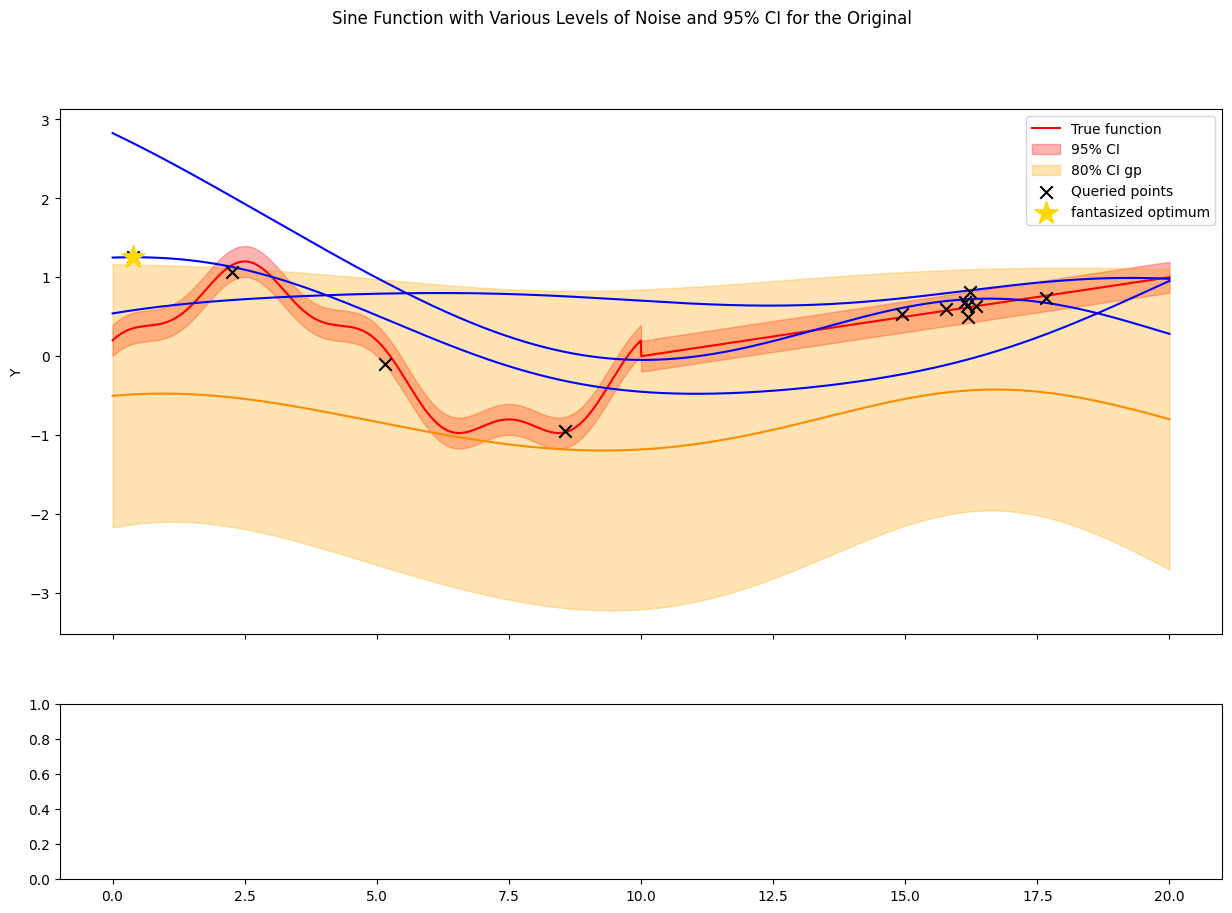

In [44]:
plot_samples_gp(X_test, 0.1, synthetic_function, tnorm_mean,samples,chosen_go_index, X_with_new_max[chosen_go_index], Y_with_new_max[chosen_go_index], tnorm_var, last=True)

In [351]:
means

tensor([[ 7.7703e-04,  7.7138e-04,  7.7348e-04,  ...,  7.7664e-04,
          7.7749e-04,  7.6258e-04],
        [-4.1308e-03,  5.1024e-01,  1.4568e+00,  ...,  4.1530e-01,
         -8.5726e-01,  9.2186e-01],
        [ 3.2889e-03,  3.2872e-03,  3.2843e-03,  ...,  3.2872e-03,
          3.2886e-03,  3.2831e-03],
        ...,
        [ 5.8233e-02,  5.8637e-02,  5.6682e-02,  ...,  5.7437e-02,
          5.7967e-02,  5.8591e-02],
        [ 3.9672e-03,  3.9672e-03,  3.9672e-03,  ...,  3.9672e-03,
          3.9672e-03,  3.9672e-03],
        [ 1.2486e-02,  9.2762e-01,  1.0610e+00,  ...,  3.8892e-01,
         -8.6571e-01,  9.4993e-01]], dtype=torch.float64)

In [352]:
tnorm_mean

tensor([[-4.8656e+00, -4.8656e+00, -4.8656e+00,  ..., -4.8656e+00,
         -4.8656e+00, -4.8657e+00],
        [-5.1714e-02,  4.5833e-01,  1.4315e+00,  ...,  3.7259e-01,
         -9.0904e-01,  8.7329e-01],
        [-6.8839e-01, -6.8839e-01, -6.8839e-01,  ..., -6.8839e-01,
         -6.8839e-01, -6.8839e-01],
        ...,
        [-3.4972e+00, -3.4970e+00, -3.4992e+00,  ..., -3.4982e+00,
         -3.4975e+00, -3.4975e+00],
        [-6.3554e-01, -6.3554e-01, -6.3554e-01,  ..., -6.3554e-01,
         -6.3554e-01, -6.3554e-01],
        [-3.4810e-03,  9.1297e-01,  1.0434e+00,  ...,  3.7456e-01,
         -8.8412e-01,  9.3302e-01]], dtype=torch.float64)

In [353]:
num_optima=3
path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([num_optima]))
size_grid = X_test.size()[0]
samples =path(X_test)
max_obj = samples.max(dim=2)
maximun_index = max_obj[1]
maximuns = max_obj[0]
X_to_condition_complete = X_test[maximun_index]
list_means, list_variances = [], []
for index in range(num_optima):
    X_to_condition= X_to_condition_complete[index, :,:].unsqueeze(1)
    Y_to_condition = maximuns[index].unsqueeze(1)
    n_models = samples.size()[1]
    X_with_new_max = torch.cat([X.repeat(n_models,1,1), X_to_condition], dim=1)
    Y_with_new_max = torch.cat([Y.repeat(n_models,1,1).squeeze(), Y_to_condition], dim=1)
    batch_gp = BatchGPModel(X_with_new_max,
             Y_with_new_max,
             dimensions=DIM,
             batch_size=n_models)
    batch_gp.load_params(gp.get_param_dict())
    batch_gp.eval()
    batch_gp.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = batch_gp.likelihood(batch_gp(X_test))
        list_means.append(predictions.mean.unsqueeze(-1))
        list_variances.append(predictions.variance.unsqueeze(-1))
all_means = torch.cat(list_means, -1).swapaxes(-1,1)
all_vars = torch.cat(list_variances, -1).swapaxes(-1,1)
all_maxs = maximuns.unsqueeze(-1).repeat(1,1,size_grid).detach().swapaxes(0,1)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 7864320000 bytes.

In [ ]:
X_test.size()[0]

10000

In [ ]:
def normal_to_truncnorm(all_means, all_vars, all_maxs):
    #https://en.wikipedia.org/wiki/Truncated_normal_distribution
    Norm = torch.distributions.normal.Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
    pdf_betas=Norm.log_prob(all_maxs).exp()
    cdf_betas = Norm.cdf(all_maxs)
    tnorm_mean = all_means -torch.sqrt(all_vars)*pdf_betas.div(cdf_betas)
    right = pdf_betas.div(cdf_betas)
    right = right.pow(2)
    left = all_maxs*pdf_betas.div(cdf_betas) 
    tnorm_var = 1-left-right
    tnorm_var = all_vars*tnorm_var
    return tnorm_mean, tnorm_var

In [ ]:
def get_truncated_moments(gp, X_test,X, Y, dim, num_optima=3):
    path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([num_optima]))
    samples =path(X_test)
    n_models = samples.size()[1]
    size_grid = X_test.size()[0]
    max_obj = samples.max(dim=2)
    maximun_index = max_obj[1]
    maximuns = max_obj[0]
    X_to_condition_complete = X_test[maximun_index]
    list_means, list_variances = [], []
    for index in range(num_optima):
        X_to_condition= X_to_condition_complete[index, :,:].unsqueeze(1)
        Y_to_condition = maximuns[index].unsqueeze(1)
        X_with_new_max = torch.cat([X.repeat(n_models,1,1), X_to_condition], dim=1)
        Y_with_new_max = torch.cat([Y.repeat(n_models,1,1).squeeze(), Y_to_condition], dim=1)
        batch_gp = BatchGPModel(X_with_new_max,
                Y_with_new_max,
                dimensions=DIM,
                batch_size=n_models)
        batch_gp.load_params(gp.get_param_dict())
        batch_gp.eval()
        batch_gp.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = batch_gp.likelihood(batch_gp(X_test))
            list_means.append(predictions.mean.unsqueeze(-1))
            list_variances.append(predictions.variance.unsqueeze(-1))
    all_means = torch.cat(list_means, -1).swapaxes(-1,1)
    all_vars = torch.cat(list_variances, -1).swapaxes(-1,1)
    all_maxs = maximuns.unsqueeze(-1).repeat(1,1,size_grid).detach().swapaxes(0,1)
    tnorm_mean, tnorm_var = normal_to_truncnorm(all_means, all_vars, all_maxs)
    return tnorm_mean, tnorm_var

In [ ]:
tnorm_mean, tnorm_var = get_truncated_moments(gp, X_test[:1000], 3)

In [ ]:
tnorm_var.size()

torch.Size([32, 3, 10000])

In [ ]:
# Assuming new_x and new_y are your new data points with appropriate batch dimensions
# new_x of shape [Batch, New Points, Features]
# new_y of shape [Batch, New Points]

# Update model with new data (assuming new_x and new_y are tensors with batch dimensions)
gp.set_train_data(inputs=torch.cat([X.repeat(44,1,1), X_to_condition], dim=1), 
                     targets=torch.cat([Y.repeat(44,1,1).squeeze(), Y_to_condition], dim=1), 
                     strict=False)

# Optionally, re-optimize the model parameters here

In [ ]:
dictss = gp.get_param_dict()
dictss['noise'].size()

torch.Size([44, 1])

In [ ]:
y_hat = get_yhat(gp, X_test, tkwargs)
y_hat.size()

torch.Size([10, 1000, 100, 1])

In [ ]:
posterior = gp.posterior(X_test)
Y_full = posterior.mean

In [ ]:
Y_full.size()

torch.Size([44, 44, 10000, 1])

In [ ]:
gp.train_targets

tensor([ 0.6783,  0.7889,  0.1905, -0.0765,  0.9319, -0.6050, -1.9081],
       dtype=torch.float64)

In [ ]:
Y_full[1,:]

tensor([[[0.3244],
         [0.3244],
         [0.3244],
         ...,
         [0.3244],
         [0.3244],
         [0.3244]],

        [[0.3130],
         [0.4717],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5490]],

        [[0.4137],
         [0.4137],
         [0.4137],
         ...,
         [0.4137],
         [0.4137],
         [0.4137]],

        ...,

        [[0.2992],
         [0.2992],
         [0.2992],
         ...,
         [0.2992],
         [0.2992],
         [0.2992]],

        [[0.3299],
         [0.4626],
         [0.3543],
         ...,
         [0.3134],
         [0.3114],
         [0.5963]],

        [[0.3175],
         [0.4641],
         [0.3250],
         ...,
         [0.2865],
         [0.2904],
         [0.5520]]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [ ]:
Y_full[:,1]

tensor([[[0.3130],
         [0.4509],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5147]],

        [[0.3130],
         [0.4717],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5490]],

        [[0.3130],
         [0.4509],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5147]],

        ...,

        [[0.3130],
         [0.4509],
         [0.2905],
         ...,
         [0.2717],
         [0.2728],
         [0.5487]],

        [[0.3130],
         [0.4509],
         [0.2905],
         ...,
         [0.2717],
         [0.2728],
         [0.5487]],

        [[0.3129],
         [0.4427],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5487]]], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [ ]:
y_hat[1,:,:].size()

torch.Size([200, 1])

In [ ]:
Y_full[0,1,:,:]

tensor([[0.4846],
        [0.5124],
        [0.4453],
        ...,
        [0.4607],
        [0.4750],
        [0.5348]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [ ]:
y_hat.size()

torch.Size([10, 1000, 100, 1])

In [ ]:
Y_full[0,1,:,:]

tensor([[0.4846],
        [0.5124],
        [0.4453],
        ...,
        [0.4607],
        [0.4750],
        [0.5348]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [200]:
y_hat = get_yhat(gp, X_test, tkwargs)
plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y,acq_values_all, weights)

AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
X_test.size()

torch.Size([10000, 1])

In [ ]:
Y.repeat(22,1,1).size()

torch.Size([22, 93, 1])

In [ ]:
torch.cat([Y.repeat(22,1,1), Y_to_condition], dim=1)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [ ]:
torch.cat([X.repeat(22,1,1), X_to_condition], dim=1)

tensor([[[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [9.9994e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.3738e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [7.9691e-05]],

        ...,

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.3706e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [7.9691e-05]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.2266e-01]]], dtype=torch.float64)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_samples_gp(test_X, std, synthetic_function,Y_hat, samples, index, X_train, Y_train):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    samples_selected = samples[:,index,:].detach().numpy()
    df['gp_mean'] = gps_y[index,:]
    gp_cols = ['gp_' + str(i) for i in range(len(samples_selected))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = samples_selected[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)


    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    for i, gp_col in enumerate(gp_cols):
            color = 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='gold', s=200, marker='*', label='Queried points', zorder=5)
    ax1.legend()
    ax1.plot(df.x, df.gp_mean, color='orange')
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

# Example data
train_x = torch.rand(10, 1)  # Feature vector of 10 points
train_y = torch.sin(train_x).squeeze()  # Target vector

# Define GP model
likelihood = GaussianLikelihood()
model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood)

# Model training (for completeness)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
# Here you would optimize the MLL using your choice of optimizer...

# Prepare for sampling
model.eval()  # Put the model in evaluation mode

# Sampling parameters
sample_shape = torch.Size([10])  # For example, draw 10 samples

# Draw samples
samples = draw_matheron_paths(model=model, sample_shape=sample_shape, X=train_x)


AttributeError: 'GaussianLikelihood' object has no attribute 'dim'

In [ ]:
samples[1]

NameError: name 'samples' is not defined

In [ ]:
from scipy import optimize
from scipy import stats
def mode_params(gp):
    model_dict = gp.get_param_dict()
    decomposed_param_dict = {}
    decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
    decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
    for i in range(model_dict['lengthscale'].size()[1]):
        decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()
    decomposed_param_dict['mean']  = model_dict['mean'].numpy()
    df_params = pd.DataFrame(decomposed_param_dict)
    print(df_params.head())
    array_params = df_params.values.T
    kernel = stats.gaussian_kde(array_params)
    print(kernel([0.3,0.1,2,0.3]))
    x0 = np.mean(array_params, axis=1)
    print(x0)
    bounds = [(1e-8, None) for i in range(array_params.shape[0]-1)]
    bounds.append((None,None))
    opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
    return opt

In [ ]:
def get_mode_param_dict(gp):
    model_dict = gp.get_param_dict()
    decomposed_param_dict = {}
    decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
    decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
    for i in range(model_dict['lengthscale'].size()[1]):
        decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()
    decomposed_param_dict['mean']  = model_dict['mean'].numpy()
    df_params = pd.DataFrame(decomposed_param_dict)
    array_params = df_params.values.T
    kernel = stats.gaussian_kde(array_params)
    mode_index = kernel(array_params).argmax()
    mode_df = df_params.iloc[mode_index]
    mode_dict = {}
    lenghtscales = []
    for i in range(model_dict['lengthscale'].size()[1]):
        lenghtscales.append(mode_df['legthscale_'+str(i)])
    mode_dict['lenghtscale'] = torch.Tensor([lenghtscales])
    mode_dict['noise'] = torch.Tensor([mode_df['noise']])
    mode_dict['outputscale'] = torch.Tensor([mode_df['outputscale']])
    mode_dict['mean'] = torch.Tensor([mode_df['mean']])
    return mode_dict

In [ ]:
get_mode_param_dict(gp)

{'lenghtscale': tensor([[0.0260]]),
 'noise': tensor([0.6599]),
 'outputscale': tensor([7.3203]),
 'mean': tensor([0.3864])}

In [ ]:
model_dict = gp.get_param_dict()
decomposed_param_dict = {}

In [ ]:
decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
decomposed_param_dict['mean']  = model_dict['mean'].numpy()


In [ ]:
model_dict['lengthscale'][:,0].squeeze()

tensor([1.6233e-01, 1.1975e+00, 1.9129e-01, 5.9169e+01, 2.5869e+00, 1.5540e-01,
        6.8032e-01, 7.9056e+00, 3.4115e+01, 3.5880e-01, 1.4940e+01, 5.6973e-02,
        1.2637e-01, 1.0570e+00, 4.7083e+02, 6.5810e-01, 2.7366e+01, 1.9272e-01,
        1.3235e-01, 1.0475e+01, 9.9672e+00, 4.8915e+01, 1.4266e+00, 6.7191e+01,
        1.2920e+00, 1.8823e+03, 1.2829e+03, 4.2714e-01, 1.4792e-01, 2.0337e+04,
        1.5330e+02, 1.3424e-01, 6.5015e-02, 5.1820e-02, 2.0411e-01, 7.8089e-02,
        1.2208e+01, 5.7450e-02, 1.3874e-01, 3.3885e+00, 5.8085e-02, 1.6408e-01,
        3.0256e+01, 6.1889e+00, 2.0073e-01, 1.1711e+01, 1.4645e+01, 1.2849e+01,
        2.5298e-01, 3.1044e-02, 8.4816e-02, 9.9453e-02, 3.0289e+00, 1.6640e-01,
        8.0308e+01, 3.8299e+01, 8.9504e+00, 2.0377e-01, 1.3112e-01, 1.8488e+03,
        6.8935e+00, 1.4953e-01, 1.3815e-01, 5.6904e-02], dtype=torch.float64)

In [ ]:
for i in range(model_dict['lengthscale'].size()[1]):
    decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()

In [ ]:
df_params = pd.DataFrame(decomposed_param_dict)
array_params = df_params.values.T

In [ ]:
from scipy import optimize
from scipy import stats

In [ ]:
kernel = stats.gaussian_kde(array_params)
# Minimize the negative instead of maximizing
# Depending on the shape of your data, you might want to set some bounds
#opt = optimize.minimize_scalar(lambda x: -kernel(x))

In [ ]:
kernel([0,0,1,1])

array([4.35810156e-09])

In [ ]:
x0 = np.ones(array_params.shape[0])


In [ ]:
bounds = [(1e-8, None) for i in range(array_params.shape[0])]

In [ ]:
def neg_kde_value(x):
    return -kernel(x)

In [ ]:
opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
opt

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -4.4480964546513785e-09
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [-1.422e-12 -8.139e-11  8.272e-09  1.191e-14]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
-kernel(array_params[:,15])

array([-2.69676111e-10])

In [ ]:
array_params[:,1]

array([69.55141666, 19.48010123,  0.96881813,  1.19751402])